# Initialization


In [ ]:
import os
import seaborn as sns
import zipfile
import pandas as pd
import re
import numpy as np
from gensim.models.word2vec import Word2Vec
from google.colab import drive
import matplotlib.pyplot as plt
!pip install kaggle
!kaggle datasets download -d julian3833/jigsaw-toxic-comment-classification-challenge

drive.mount('/content/drive')

os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

# Define the path to your zip file
file_path = '/content/jigsaw-toxic-comment-classification-challenge.zip'  # Replace 'your_file.zip' with your file's name

if not os.path.isdir('/content/data'):
    os.mkdir('/content/data')
# Unzip the file to a specific destination
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/data')  # Replace 'destination_folder' with your desired folder


100% 53.4M/53.4M [00:03<00:00, 20.5MB/s]
100% 53.4M/53.4M [00:03<00:00, 15.8MB/s]
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
test_labels = pd.read_csv('data/test_labels.csv')

## Sampling

In [ ]:
from scipy.optimize import nnls
toxic_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# conditional probability matrix
def build_conditional_prob_matrix(df, labels):
    cooc = df[labels].values.T.dot(df[labels].values)
    cooc_norm = cooc.copy().astype(np.float32)
    for i in range(cooc_norm.shape[0]):
        cooc_norm[:, i] /= cooc[i, i]
    return cooc_norm

cooc_norm = build_conditional_prob_matrix(train, toxic_labels)
cooc_df = pd.DataFrame(cooc_norm, columns = toxic_labels, index = toxic_labels)
cooc_df.style.background_gradient(cmap = 'coolwarm')

In [ ]:
def fancy_sample(df, labels, target_count, cond_prob):
    target_counts = np.array([target_count for _ in labels])
    optimal_samples, residuals = nnls(cond_prob, target_counts)
    optimal_samples = np.ceil(optimal_samples).astype(np.int32)

    df_subs = []
    for i, label in enumerate(labels):
        sub_df = df[df[label] == 1]
        df_subs.append(sub_df.sample(optimal_samples[i],
                                     replace = len(sub_df) < optimal_samples[i]))
    sampled_df = pd.concat(df_subs)
    return sampled_df

x = fancy_sample(train, toxic_labels, 1000, cooc_norm)
resampled_df_labels = x[toxic_labels]
print(len(x))
resampled_df_labels.sum()

1448


toxic            1384
severe_toxic      590
obscene          1090
threat            728
insult           1102
identity_hate     651
dtype: int64

In [ ]:
new_train = pd.DataFrame()
for i in range(50):
    sampled_result = fancy_sample(train, toxic_labels, 5000, cooc_norm)
    new_train = pd.concat([new_train, sampled_result], ignore_index=True)

In [ ]:
train.head(10)

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   
5  00025465d4725e87  "\n\nCongratulations from me as well, use the ...      0   
6  0002bcb3da6cb337       COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK      1   
7  00031b1e95af7921  Your vandalism to the Matt Shirvington article...      0   
8  00037261f536c51d  Sorry if the word 'nonsense' was offensive to ...      0   
9  00040093b2687caa  alignment on this subject and which are contra...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  
5             0        0       0       0              0  
6             1        1       0       1              0  
7             0        0       0       0              0  
8             0        0       0       0              0  
9             0        0       0       0              0

In [ ]:
train['comment_text'].head(1)

0    Explanation\nWhy the edits made under my usern...
Name: comment_text, dtype: object

In [ ]:
list(train['comment_text'].head(1))

["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"]

In [ ]:
str(train['comment_text'].head(1))

'0    Explanation\\nWhy the edits made under my usern...\nName: comment_text, dtype: object'

In [ ]:
train.loc[train.index[0], 'comment_text']

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [ ]:
test.head(10)

id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
5  0001ea8717f6de06  Thank you for understanding. I think very high...
6  00024115d4cbde0f  Please do not add nonsense to Wikipedia. Such ...
7  000247e83dcc1211                   :Dear god this site is horrible.
8  00025358d4737918  " \n Only a fool can believe in such numbers. ...
9  00026d1092fe71cc  == Double Redirects == \n\n When fixing double...

In [ ]:
test_labels.head(10)

id  toxic  severe_toxic  obscene  threat  insult  \
0  00001cee341fdb12     -1            -1       -1      -1      -1   
1  0000247867823ef7     -1            -1       -1      -1      -1   
2  00013b17ad220c46     -1            -1       -1      -1      -1   
3  00017563c3f7919a     -1            -1       -1      -1      -1   
4  00017695ad8997eb     -1            -1       -1      -1      -1   
5  0001ea8717f6de06      0             0        0       0       0   
6  00024115d4cbde0f     -1            -1       -1      -1      -1   
7  000247e83dcc1211      0             0        0       0       0   
8  00025358d4737918     -1            -1       -1      -1      -1   
9  00026d1092fe71cc     -1            -1       -1      -1      -1   

   identity_hate  
0             -1  
1             -1  
2             -1  
3             -1  
4             -1  
5              0  
6             -1  
7              0  
8             -1  
9             -1

In [ ]:
filtered_test_labels = test_labels.loc[(test_labels != -1).all(axis=1)]
len(filtered_test_labels)/(len(train)+len(filtered_test_labels))

0.28619228893889037

In [ ]:
filtered_test_labels

id  toxic  severe_toxic  obscene  threat  insult  \
5       0001ea8717f6de06      0             0        0       0       0   
7       000247e83dcc1211      0             0        0       0       0   
11      0002f87b16116a7f      0             0        0       0       0   
13      0003e1cccfd5a40a      0             0        0       0       0   
14      00059ace3e3e9a53      0             0        0       0       0   
...                  ...    ...           ...      ...     ...     ...   
153150  fff8f64043129fa2      0             0        0       0       0   
153151  fff9d70fe0722906      0             0        0       0       0   
153154  fffa8a11c4378854      0             0        0       0       0   
153155  fffac2a094c8e0e2      1             0        1       0       1   
153156  fffb5451268fb5ba      0             0        0       0       0   

        identity_hate  
5                   0  
7                   0  
11                  0  
13                  0  
14                  0  
...               ...  
153150              0  
153151              0  
153154              0  
153155              0  
153156              0  

[63978 rows x 7 columns]

<ipython-input-17-af7100c40d8e>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=label_counts.values,


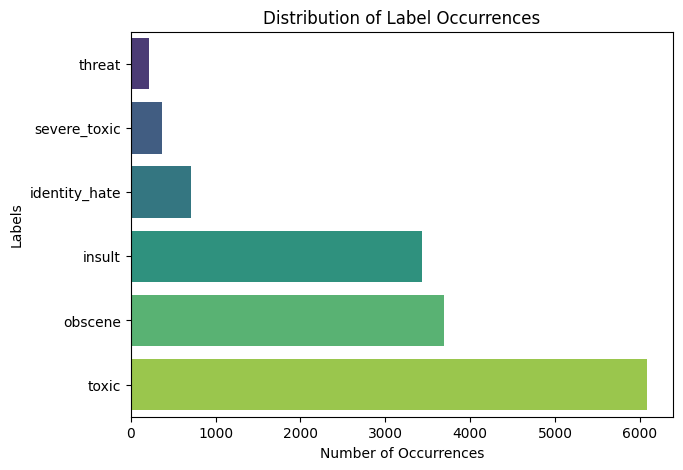

In [ ]:
column_labels = filtered_test_labels.columns.tolist()[1:]
label_counts = filtered_test_labels[column_labels].sum().sort_values()


# Create a black background for the plot
plt.figure(figsize=(7, 5))

# Create a horizontal bar plot using Seaborn
ax = sns.barplot(x=label_counts.values,
                 y=label_counts.index, palette='viridis')


# Add labels and title to the plot
plt.xlabel('Number of Occurrences')
plt.ylabel('Labels')
plt.title('Distribution of Label Occurrences')

# Show the plot
plt.show()

<ipython-input-18-435056213fdc>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Count', y='Category', data=plot_data, palette='viridis')


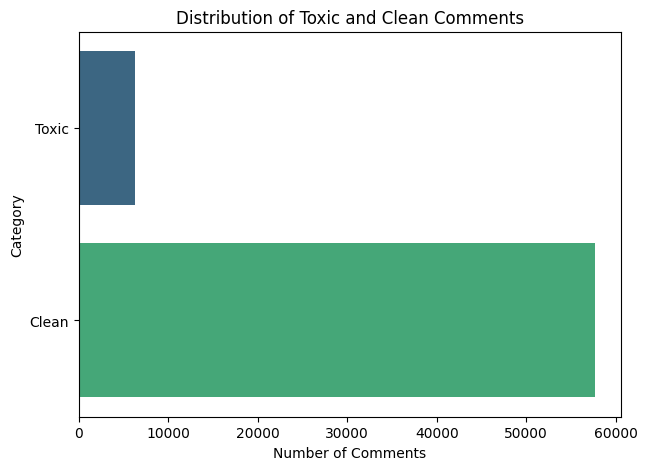

In [ ]:
# Create subsets based on toxic and clean comments
column_labels = filtered_test_labels.columns.tolist()[1:]
train_toxic = filtered_test_labels[filtered_test_labels[column_labels].sum(axis=1) > 0]
train_clean = filtered_test_labels[filtered_test_labels[column_labels].sum(axis=1) == 0]

# Number of toxic and clean comments
num_toxic = len(train_toxic)
num_clean = len(train_clean)

# Create a DataFrame for visualization
plot_data = pd.DataFrame(
    {'Category': ['Toxic', 'Clean'], 'Count': [num_toxic, num_clean]})

# Create a black background for the plot
plt.figure(figsize=(7, 5))

# Horizontal bar plot
ax = sns.barplot(x='Count', y='Category', data=plot_data, palette='viridis')


# Add labels and title to the plot
plt.xlabel('Number of Comments')
plt.ylabel('Category')
plt.title('Distribution of Toxic and Clean Comments')

# Set ticks' color to white
ax.tick_params()

# Show the plot
plt.show()

<ipython-input-19-ce27aaeff230>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=label_counts.values,


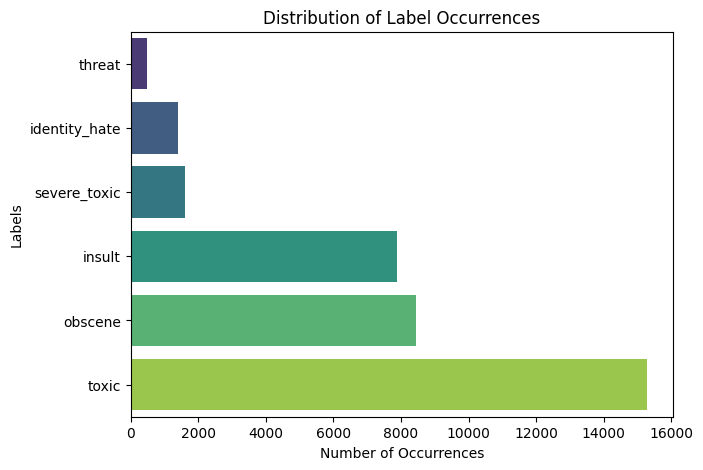

In [ ]:

# Visualizing the class distribution of the 'label' column
column_labels = train.columns.tolist()[2:]
label_counts = train[column_labels].sum().sort_values()


# Create a black background for the plot
plt.figure(figsize=(7, 5))

# Create a horizontal bar plot using Seaborn
ax = sns.barplot(x=label_counts.values,
                 y=label_counts.index, palette='viridis')


# Add labels and title to the plot
plt.xlabel('Number of Occurrences')
plt.ylabel('Labels')
plt.title('Distribution of Label Occurrences')

# Show the plot
plt.show()


<ipython-input-20-e1930aff1c74>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Count', y='Category', data=plot_data, palette='viridis')


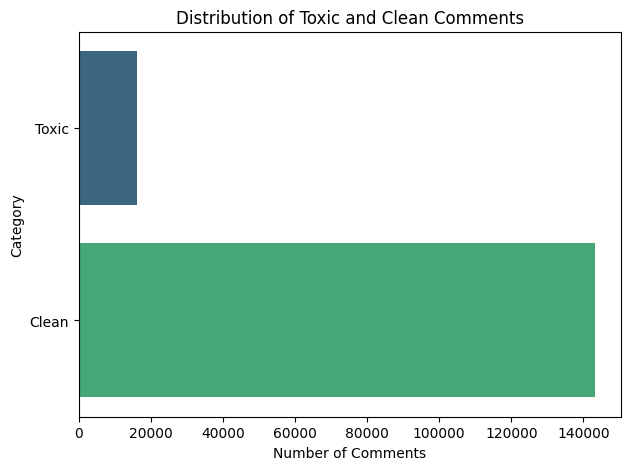

In [ ]:
# Create subsets based on toxic and clean comments
column_labels = train.columns.tolist()[2:]
train_toxic = train[train[column_labels].sum(axis=1) > 0]
train_clean = train[train[column_labels].sum(axis=1) == 0]

# Number of toxic and clean comments
num_toxic = len(train_toxic)
num_clean = len(train_clean)

# Create a DataFrame for visualization
plot_data = pd.DataFrame(
    {'Category': ['Toxic', 'Clean'], 'Count': [num_toxic, num_clean]})

# Create a black background for the plot
plt.figure(figsize=(7, 5))

# Horizontal bar plot
ax = sns.barplot(x='Count', y='Category', data=plot_data, palette='viridis')


# Add labels and title to the plot
plt.xlabel('Number of Comments')
plt.ylabel('Category')
plt.title('Distribution of Toxic and Clean Comments')

# Set ticks' color to white
ax.tick_params()

# Show the plot
plt.show()

In [ ]:
RE_PATTERNS = {
    ' american ':
        [
            'amerikan'
        ],

    ' adolf ':
        [
            'adolf'
        ],


    ' hitler ':
        [
            'hitler'
        ],

    ' fuck':
        [
            '(f)(u|[^a-z0-9 ])(c|[^a-z0-9 ])(k|[^a-z0-9 ])([^ ])*',
            '(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)',
            ' f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*k', 'f u u c',
            '(f)(c|[^a-z ])(u|[^a-z ])(k)', r'f\*',
            'feck ', ' fux ', 'f\*\*',
            'f\-ing', 'f\.u\.', 'f###', ' fu ', 'f@ck', 'f u c k', 'f uck', 'f ck'
        ],

    ' ass ':
        [
            '[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\$\$'
                                                           '[^a-z]anus', ' a\*s\*s', '[^a-z]ass[^a-z ]',
            'a[@#\$%\^&\*][@#\$%\^&\*]', '[^a-z]anal ', 'a s s'
        ],

    ' ass hole ':
        [
            ' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\$\$hole'
        ],

    ' bitch ':
        [
            'b[w]*i[t]*ch', 'b!tch',
            'bi\+ch', 'b!\+ch', '(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)',
            'biatch', 'bi\*\*h', 'bytch', 'b i t c h'
        ],

    ' bastard ':
        [
            'ba[s|z]+t[e|a]+rd'
        ],

    ' trans gender':
        [
            'transgender'
        ],

    ' gay ':
        [
            'gay'
        ],

    ' cock ':
        [
            '[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
            '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'
        ],

    ' dick ':
        [
            ' dick[^aeiou]', 'deek', 'd i c k'
        ],

    ' suck ':
        [
            'sucker', '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'sucks', '5uck', 's u c k'
        ],

    ' cunt ':
        [
            'cunt', 'c u n t'
        ],

    ' bull shit ':
        [
            'bullsh\*t', 'bull\$hit'
        ],

    ' homo sex ual':
        [
            'homosexual'
        ],

    ' jerk ':
        [
            'jerk'
        ],

    ' idiot ':
        [
            'i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)', 'idiots'
                                                                                      'i d i o t'
        ],

    ' dumb ':
        [
            '(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'
        ],

    ' shit ':
        [
            'shitty', '(s)([^a-z ]*)(h)([^a-z ]*)(i)([^a-z ]*)(t)', 'shite', '\$hit', 's h i t'
        ],

    ' shit hole ':
        [
            'shythole'
        ],

    ' retard ':
        [
            'returd', 'retad', 'retard', 'wiktard', 'wikitud'
        ],

    ' rape ':
        [
            ' raped'
        ],

    ' dumb ass':
        [
            'dumbass', 'dubass'
        ],

    ' ass head':
        [
            'butthead'
        ],

    ' sex ':
        [
            'sexy', 's3x', 'sexuality'
        ],


    ' nigger ':
        [
            'nigger', 'ni[g]+a', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r'
        ],

    ' shut the fuck up':
        [
            'stfu'
        ],

    ' pussy ':
        [
            'pussy[^c]', 'pusy', 'pussi[^l]', 'pusses'
        ],

    ' faggot ':
        [
            'faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
            '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot', 'fae[g]+ot',
        ],

    ' mother fucker':
        [
            ' motha ', ' motha f', ' mother f', 'motherucker', 'mofuckas',
        ],

    ' whore ':
        [
            'wh\*\*\*', 'w h o r e'
        ],
}

def clean_text(text,remove_repeat_text=True, remove_patterns_text=True, is_lower=True):

  if is_lower:
    text=text.lower()

  if remove_patterns_text:
    for target, patterns in RE_PATTERNS.items():
      for pat in patterns:
        text=str(text).replace(pat, target)

  if remove_repeat_text:
    text = re.sub(r'(.)\1{2,}', r'\1', text)

  text = str(text).replace("\n", " ")
  text = re.sub(r'[^\w\s]',' ',text) # zamienia wszystkie znaki niebędące literami ani cyframi na spacje
  text = re.sub('[0-9]',"",text) # usuwa wszystkie cyfry z tekstu
  text = re.sub(" +", " ", text) #redukuje serię spacji do pojedynczej spacji.
  text = re.sub("([^\x00-\x7F])+"," ",text) #usuwa znaki spoza zakresu ASCII
  return text




stop_words = set(['all', "she'll", "don't", 'being', 'over', 'through',
'yourselves', 'its', 'before', "he's", "when's", "we've", 'had', 'should',
"he'd", 'to', 'only', "there's", 'those', 'under', 'ours', 'has',
"haven't", 'do', 'them', 'his', "they'll", 'very', "who's", "they'd",
'cannot', "you've", 'they', 'not', 'during', 'yourself', 'him', 'nor',
"we'll", 'did', "they've", 'this', 'she', 'each', "won't", 'where',
"mustn't", "isn't", "i'll", "why's", 'because', "you'd", 'doing', 'some',
'up', 'are', 'further', 'ourselves', 'out', 'what', 'for', 'while',
"wasn't", 'does', "shouldn't", 'above', 'between', 'be', 'we', 'who',
"you're", 'were', 'here', 'hers', "aren't", 'by', 'both', 'about', 'would',
'of', 'could', 'against', "i'd", "weren't", "i'm", 'or', "can't", 'own',
'into', 'whom', 'down', "hadn't", "couldn't", 'your', "doesn't", 'from',
"how's", 'her', 'their', "it's", 'there', 'been', 'why', 'few', 'too',
'themselves', 'was', 'until', 'more', 'himself', "where's", "i've", 'with',
"didn't", "what's", 'but', 'herself', 'than', "here's", 'he', 'me',
"they're", 'myself', 'these', "hasn't", 'below', 'ought', 'theirs', 'my',
"wouldn't", "we'd", 'and', 'then', 'is', 'am', 'it', 'an', 'as', 'itself',
'at', 'have', 'in', 'any', 'if', 'again', 'no', 'that', 'when', 'same',
'how', 'other', 'which', 'you', "shan't", 'our', 'after', "let's", 'most',
'such', 'on', "he'll", 'a', 'off', 'i', "she'd", 'yours', "you'll", 'so',
"we're", "she's", 'the', "that's", 'having', 'once', 'i', 'me', 'my', 'myself',
'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your',
'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',
'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those',
'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do',
'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during',
'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both',
'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd',
'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn',
"doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't",
'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't",
'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
def preprocessing(data):
  data1 = data.apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))
  return [clean_text(i).split() for i in data1]


In [ ]:
#wybranie z tabeli test jedynie komentarzy, które znajdują się w filtered_test_labels i oczyszczenie ich za pomocą funkcji precprocessing
test2=test[test['id'].isin(filtered_test_labels['id'])]
test2.head()
test_prepared=preprocessing(test2['comment_text'])
test_prepared[0]

['thank',
 'understanding',
 'think',
 'highly',
 'revert',
 'without',
 'discussion']

In [ ]:
new_train_prepared = preprocessing(new_train['comment_text'])

In [ ]:
#oczyszczenie treningowych komentarzy za pomocą funkcji preprocessing
train_prepared=preprocessing(train['comment_text'])
train_prepared[0]

['explanation',
 'edits',
 'made',
 'username',
 'hardcore',
 'metallica',
 'fan',
 'reverted',
 'vandalisms',
 'closure',
 'gas',
 'voted',
 'new',
 'york',
 'dolls',
 'fac',
 'please',
 'remove',
 'template',
 'talk',
 'page',
 'since',
 'retired',
 'now']

In [ ]:
train_length = [len(i) for i in train_prepared]
test_length = [len(i) for i in test_prepared]

In [ ]:
from gensim.models import Word2Vec

list_of_lists_of_words = train_prepared

#Czym są parametry word2vec?

# The context window is the range of words around the current word that the model considers as its context

#The min_count parameter in Word2Vec is used to ignore all words with a total frequency (count) lower than the specified value during the training process.


#The workers parameter in Word2Vec determines the number of CPU cores to use during the training process. It controls the parallelization of the training,
#making it more efficient, especially when dealing with large datasets.

list_of_lists_of_words3 = new_train_prepared

model = Word2Vec(sentences=list_of_lists_of_words3, vector_size=100, window=5, min_count=1, workers=4)

new_train_word2vec = []
for word_list in list_of_lists_of_words3:
    word_vectors = [model.wv[word] for word in word_list if word in model.wv]
    mean_vector = np.mean(word_vectors, axis=0)
    new_train_word2vec.append(mean_vector)


model = Word2Vec(sentences=list_of_lists_of_words, vector_size=100, window=5, min_count=1, workers=4)

train_word2vec = []
for word_list in list_of_lists_of_words:
    word_vectors = [model.wv[word] for word in word_list if word in model.wv]
    mean_vector = np.mean(word_vectors, axis=0)
    train_word2vec.append(mean_vector)


print(train_word2vec[0].shape)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(100,)


In [ ]:
print(train_word2vec[0])

[ 0.28137287 -0.20752008 -0.0573913   0.56924134  0.09855743 -0.44247627
  0.32455358  1.4794155   0.41760173  0.00481948  0.2785553  -0.42805913
 -0.21060716  0.15496722 -0.3086051  -0.36336938  0.2505174  -0.65869457
 -0.35735288 -0.565148    0.08770653  0.24436224  0.84668446  0.16449867
 -0.8343339   0.30291367  0.01407519 -0.4282955  -0.61276513  0.4580709
 -0.06062186  0.03773052  0.61302686  0.6006493  -0.01902027  0.80554533
 -0.10038134 -0.8245074  -0.4581163  -1.18968     0.50541455 -0.5462601
  0.37442014 -0.33612177  0.40246817 -0.09599661 -0.9188738  -0.20768361
  0.519546    0.44204342  0.2894375  -0.31864157  0.34191012  0.10031006
 -0.2094057  -0.5169061  -0.36895263  0.59465486 -0.15795548  0.2560698
  0.2156676   0.41013804 -0.40229997  0.04353164 -0.8159468  -0.4018384
  0.37478325 -0.2214603  -0.6989482   0.7708318  -0.51675564 -0.31058595
  0.62541443 -0.68972254 -0.19411539 -0.00214498  0.5163098  -0.21787126
 -0.01306617  0.03685065 -0.86030644 -0.06583544 -0.438

In [ ]:
list_of_lists_of_words2 = test_prepared




test_word2vec = []
for word_list in list_of_lists_of_words2:
    word_vectors = [model.wv[word] for word in word_list if word in model.wv]
    mean_vector = np.mean(word_vectors, axis=0)
    test_word2vec.append(mean_vector)


print(test_word2vec[0])

[ 0.40431905 -0.19917296 -0.3396627   1.5335929   0.5255593  -1.451392
  0.4204829   1.2257111  -0.35112152  0.94502765  1.4338869  -1.1445967
  1.0672206   0.13312666  0.519303   -0.50146776  0.15416016 -0.9867903
 -0.15697333 -1.4748489   0.8315322   0.30170172  1.2704995  -0.12920725
 -0.8345927  -0.55443746 -2.12885    -0.2881824  -0.2057332  -0.17207363
 -0.521633    1.5558687   0.9594263   0.7181195   0.14376543  0.6232805
  0.37426987 -1.5247762  -0.75336295 -0.2944922   1.4055511  -0.6837931
 -0.12293973 -0.6718588   0.29260752 -0.25605723 -1.1820549   0.45345208
  0.56077445 -0.09520388  0.5155454  -0.08077025  0.76979786 -1.0530922
  0.18863024  0.20155366  0.04421121  0.6605652  -1.0177289   0.67471915
 -1.2866355   0.26307827 -0.5146508   0.6231676  -1.4155804  -0.6804715
  0.45319125 -0.94436646 -0.12528732  1.4857285  -1.3068067  -0.55402786
  1.1176926  -0.8011896   0.71587294 -0.2976465   1.0092889  -0.53386605
  0.74055725 -0.30932134 -0.47986275 -0.9802622  -0.8131441

In [ ]:
def check_type(data):
  typ=type(data[0])
  indexy=[]
  j=0
  for i in data:
    if type(i)!=typ:
      indexy.append(j)
    j+=1
  return indexy

In [ ]:
new_X_train = new_train_word2vec

In [ ]:
new_y_train= new_train.filter(items=['toxic', 	'severe_toxic', 	'obscene',	'threat', 	'insult', 	'identity_hate'])
print(len(new_y_train))

361800


In [ ]:
X_train=train_word2vec
print(len(X_train))
faulty_idx=check_type(X_train)
print(len(faulty_idx))

159571
22


In [ ]:
y_train= train.filter(items=['toxic', 	'severe_toxic', 	'obscene',	'threat', 	'insult', 	'identity_hate'])
y_train.head()
print(len(y_train))

159571


In [ ]:
y_test=filtered_test_labels.filter(items=['toxic', 	'severe_toxic', 	'obscene',	'threat', 	'insult', 	'identity_hate'])
y_test.head()
print(len(y_test))

63978


In [ ]:
X_test=test_word2vec
print(len(X_test))
faulty_idx2=check_type(X_test)
print(len(faulty_idx2))

63978
602


In [ ]:
y_train=y_train.values.tolist()
y_test=y_test.values.tolist()
print(type(X_train), type(y_train), type(X_test), type(y_test))

<class 'list'> <class 'list'> <class 'list'> <class 'list'>


## Length analysis

In [ ]:
train_length = np.array(train_length)
test_length = np.array(test_length)
Ly_train = np.array([1 if 1 in i else 0 for i in y_train])
Ly_test = np.array([1 if 1 in i else 0 for i in y_test])
indexes0 = np.where(Ly_train == 0)[0]
indexes1 = np.where(Ly_train == 1)[0]

36.991524004855385

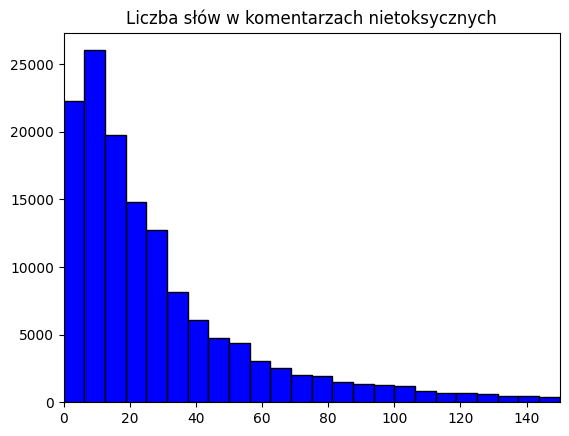

In [ ]:
plt.hist(train_length[indexes0], bins=200, color='blue', edgecolor='black')
plt.title('Liczba słów w komentarzach nietoksycznych')
plt.xlim(0, 150)
np.mean(train_length[indexes0])

30.679876733436057

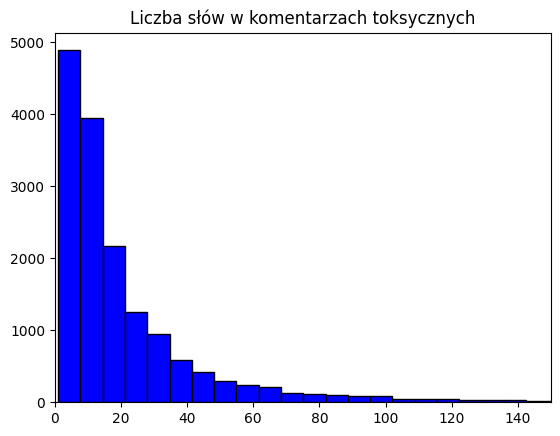

In [ ]:
plt.hist(train_length[indexes1], bins=200, color='blue', edgecolor='black')
plt.title('Liczba słów w komentarzach toksycznych')
plt.xlim(0, 150)
np.mean(train_length[indexes1])

In [ ]:
np.median(train_length[indexes0])

20.0

In [ ]:
np.median(train_length[indexes1])

13.0

 1. Średnia długość komentarzy nietoksycznych jest większa niż średnia długość komentarzy toksycznych. To samo można powiedzieć o medianie.

 2. Histogram toksycznych jest malejący, a nietoksycznych nie.

 **Czy badanie liczby słów to dobre kryterium?**

In [ ]:
train_length_reshaped = train_length.reshape(-1, 1)
test_length_reshaped = test_length.reshape(-1, 1)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

classifier = LogisticRegression()
classifier.fit(train_length_reshaped, Ly_train)

y_pred = classifier.predict(test_length_reshaped)

print("Dokładność:", accuracy_score(Ly_test, y_pred))

Dokładność: 0.90241958173122


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Ly_test, y_pred)

array([[57735,     0],
       [ 6243,     0]])

In [ ]:
selected_indexes = np.random.choice(indexes0, size=int(len(indexes0)/6), replace=False)
selected_indexes0 = train_length[selected_indexes]
selected_indexes = np.concatenate([selected_indexes0, indexes1])
train_length = train_length[selected_indexes]
Ly_train = Ly_train[selected_indexes]
len(train_length)

40116

In [ ]:
len(selected_indexes0)

23891

In [ ]:
len(indexes1)

16225

In [ ]:
train_length_reshaped = train_length.reshape(-1, 1)
test_length_reshaped = test_length.reshape(-1, 1)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

classifier = LogisticRegression()
classifier.fit(train_length_reshaped, Ly_train)

y_pred = classifier.predict(test_length_reshaped)

print("Dokładność:", accuracy_score(Ly_test, y_pred))

Dokładność: 0.6011285129263184


In [ ]:
confusion_matrix(Ly_test, y_pred)

array([[34422, 23313],
       [ 2206,  4037]])

Nie jest to dobre kryterium :(

In [ ]:
y_train

[[0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 1, 1],
 [1, 0, 1, 0, 1, 0],
 [1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0,

In [ ]:
y_test

[[0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 1, 1],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0,

In [ ]:
X_train

[array([ 0.28137287, -0.20752008, -0.0573913 ,  0.56924134,  0.09855743,
        -0.44247627,  0.32455358,  1.4794155 ,  0.41760173,  0.00481948,
         0.2785553 , -0.42805913, -0.21060716,  0.15496722, -0.3086051 ,
        -0.36336938,  0.2505174 , -0.65869457, -0.35735288, -0.565148  ,
         0.08770653,  0.24436224,  0.84668446,  0.16449867, -0.8343339 ,
         0.30291367,  0.01407519, -0.4282955 , -0.61276513,  0.4580709 ,
        -0.06062186,  0.03773052,  0.61302686,  0.6006493 , -0.01902027,
         0.80554533, -0.10038134, -0.8245074 , -0.4581163 , -1.18968   ,
         0.50541455, -0.5462601 ,  0.37442014, -0.33612177,  0.40246817,
        -0.09599661, -0.9188738 , -0.20768361,  0.519546  ,  0.44204342,
         0.2894375 , -0.31864157,  0.34191012,  0.10031006, -0.2094057 ,
        -0.5169061 , -0.36895263,  0.59465486, -0.15795548,  0.2560698 ,
         0.2156676 ,  0.41013804, -0.40229997,  0.04353164, -0.8159468 ,
        -0.4018384 ,  0.37478325, -0.2214603 , -0.6

In [ ]:
X_test

[array([ 0.40431905, -0.19917296, -0.3396627 ,  1.5335929 ,  0.5255593 ,
        -1.451392  ,  0.4204829 ,  1.2257111 , -0.35112152,  0.94502765,
         1.4338869 , -1.1445967 ,  1.0672206 ,  0.13312666,  0.519303  ,
        -0.50146776,  0.15416016, -0.9867903 , -0.15697333, -1.4748489 ,
         0.8315322 ,  0.30170172,  1.2704995 , -0.12920725, -0.8345927 ,
        -0.55443746, -2.12885   , -0.2881824 , -0.2057332 , -0.17207363,
        -0.521633  ,  1.5558687 ,  0.9594263 ,  0.7181195 ,  0.14376543,
         0.6232805 ,  0.37426987, -1.5247762 , -0.75336295, -0.2944922 ,
         1.4055511 , -0.6837931 , -0.12293973, -0.6718588 ,  0.29260752,
        -0.25605723, -1.1820549 ,  0.45345208,  0.56077445, -0.09520388,
         0.5155454 , -0.08077025,  0.76979786, -1.0530922 ,  0.18863024,
         0.20155366,  0.04421121,  0.6605652 , -1.0177289 ,  0.67471915,
        -1.2866355 ,  0.26307827, -0.5146508 ,  0.6231676 , -1.4155804 ,
        -0.6804715 ,  0.45319125, -0.94436646, -0.1

In [ ]:

def delete_idx(my_list, idx_to_remove):
  z=[my_list[i] for i in range(len(my_list)) if i not in idx_to_remove]
  return z



X_train=delete_idx(X_train, faulty_idx)
y_train=delete_idx(y_train, faulty_idx)
X_test=delete_idx(X_test, faulty_idx2)
y_test=delete_idx(y_test, faulty_idx2)

print(len(X_train), len(y_train), len(X_test), len(y_test))


159549 159549 63376 63376


Przygotowanie zbioru treningowego i testowego - danych oraz labeli

# 2D visualization


Visualization of vectors corresponding to toxic and clean comments (intially 100-dimentional) in two dimentions using T-SNE

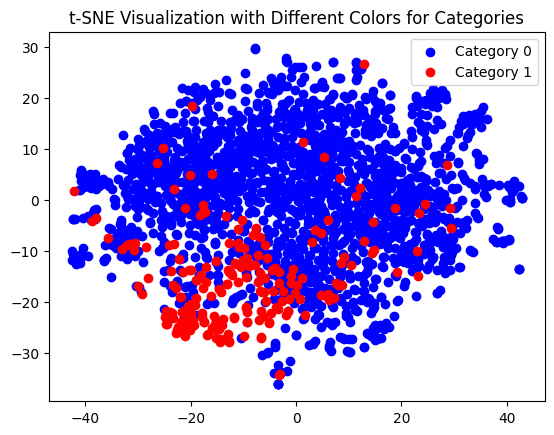

In [ ]:
labels = np.array([1 if sum(sublist) > 0 else 0 for sublist in y_train][:2000])
vectors=np.array(X_train[:2000])

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE



tsne = TSNE(n_components=2, random_state=42)
vectors_2d = tsne.fit_transform(vectors)

group_0 = vectors_2d[labels == 0]
group_1 = vectors_2d[labels == 1]

plt.scatter(group_0[:, 0], group_0[:, 1], c='blue', label='Category 0')
plt.scatter(group_1[:, 0], group_1[:, 1], c='red', label='Category 1')

plt.legend()


plt.title('t-SNE Visualization with Different Colors for Categories')


plt.show()

In [ ]:
model.wv.most_similar('fuck')

[('asswipe', 0.6838952302932739),
 ('asshole', 0.6825242638587952),
 ('mumbo', 0.6744067668914795),
 ('fck', 0.6733378171920776),
 ('fuckers', 0.6733297109603882),
 ('fuk', 0.6687803268432617),
 ('suppressing', 0.6657482385635376),
 ('piss', 0.6648798584938049),
 ('latah', 0.6626901626586914),
 ('bitch', 0.6625935435295105)]

In [ ]:
model.wv.most_similar('asshole')

[('douchebag', 0.849696695804596),
 ('prick', 0.8475197553634644),
 ('goddamn', 0.8385376334190369),
 ('motherfucker', 0.8248206377029419),
 ('youre', 0.8234979510307312),
 ('morons', 0.8181756734848022),
 ('douche', 0.8103271126747131),
 ('scum', 0.8101487755775452),
 ('peneltized', 0.8062231540679932),
 ('loser', 0.7981992363929749)]

In [ ]:
model.wv.most_similar('bitch')

[('ass', 0.825639009475708),
 ('motherfucker', 0.8255040049552917),
 ('goddamn', 0.820270299911499),
 ('fat', 0.8200876116752625),
 ('nerd', 0.8164445161819458),
 ('prick', 0.814471960067749),
 ('fuckin', 0.8140382170677185),
 ('yall', 0.8118548393249512),
 ('hes', 0.8078902959823608),
 ('fuckers', 0.8072512745857239)]

In [ ]:
model.wv.most_similar('shit')

[('crap', 0.7936520576477051),
 ('worthless', 0.7922630310058594),
 ('fucking', 0.7502066493034363),
 ('scum', 0.7459919452667236),
 ('trash', 0.7358120083808899),
 ('morons', 0.7243131399154663),
 ('ass', 0.7125622034072876),
 ('garbage', 0.7088567614555359),
 ('pile', 0.7021700143814087),
 ('asshole', 0.7019094228744507)]

In [ ]:
model.wv.most_similar('happy')

[('cheers', 0.5899231433868408),
 ('glad', 0.5624784231185913),
 ('fun', 0.5516438484191895),
 ('grateful', 0.5356953740119934),
 ('hope', 0.5329458713531494),
 ('councellor', 0.5303256511688232),
 ('policemans', 0.527407169342041),
 ('hoping', 0.5201290845870972),
 ('hopefully', 0.5174015164375305),
 ('willing', 0.5111652612686157)]

In [ ]:
model.wv.most_similar('book')

[('books', 0.783896267414093),
 ('paper', 0.7212967276573181),
 ('comic', 0.6893172264099121),
 ('novel', 0.6802400350570679),
 ('writer', 0.6697524785995483),
 ('document', 0.6565154194831848),
 ('published', 0.6508047580718994),
 ('magazine', 0.6342238783836365),
 ('writings', 0.6311271786689758),
 ('journalist', 0.6299669742584229)]

In [ ]:
model.wv.most_similar('movie')

[('film', 0.8183448314666748),
 ('movies', 0.7914044857025146),
 ('episode', 0.7655929923057556),
 ('anime', 0.7571226358413696),
 ('tv', 0.737515389919281),
 ('manga', 0.7372323870658875),
 ('album', 0.7261857390403748),
 ('batman', 0.7239893674850464),
 ('promo', 0.7171144485473633),
 ('comic', 0.7149704694747925)]

In [ ]:
model.wv.most_similar('mathematics')

[('chemistry', 0.8436588644981384),
 ('biology', 0.8339684009552002),
 ('philosophy', 0.8212381601333618),
 ('linguistics', 0.8007796406745911),
 ('quantum', 0.7976094484329224),
 ('physics', 0.7926555275917053),
 ('philosophical', 0.7867074608802795),
 ('mathematical', 0.7805896401405334),
 ('epistemology', 0.7749408483505249),
 ('psychology', 0.7741394639015198)]

In [ ]:
model.wv.similarity("cake","sweet")

0.82312

In [ ]:
model.wv.similarity("soup", "sweet")

0.63507295

In [ ]:
model.wv.similarity("medicine", "sweet")

0.106478095

In [ ]:
model.wv.similarity("dumb", "stupid")

0.7721161

In [ ]:
model.wv.similarity("scholar", "stupid")

-7.634269e-06

In [ ]:
model.wv.similarity("gingerbread", "fan")

0.11650044

# Logistic regression Michał


## Preparing model


In [ ]:
# W moim kodzie biore proporcje 1/nontoxic_proportion komentarzy z hejtem oraz bez hejtu
# nontoxic_proportion wartosc maksymalna to 9 inaczej wychodzi poza ilosc danych bo domyslnie sa w proporcji 1/prawie 10
nontoxic_proportion = 9

X_train = np.array(X_train)

# Zdobywanie komentarzy i labeli toksycznych
toxic_indexes = [idx for idx, x in enumerate(y_train) if any(x)]
toxic_count = len(toxic_indexes)
toxic_comments = X_train[toxic_indexes]

# Zdobywanie komentarzy i labeli nietoksycznych
nontoxic_indexes = [idx for idx, x in enumerate(y_train) if not all(x)][0:nontoxic_proportion * toxic_count]
nontoxic_comments = X_train[nontoxic_indexes]

# Tworze nowy zbior treningowy
newX_train = np.concatenate((toxic_comments, nontoxic_comments))
newy_train = np.array([1] * toxic_count + [0] * nontoxic_proportion * toxic_count)

# Modyfikuje labele testowe

new_y_test = np.array([int(any(x)) for x in y_test])

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

LRmodel = LogisticRegression()
LRmodel.fit(newX_train, newy_train)

y_pred = LRmodel.predict(X_test)

accuracy = accuracy_score(new_y_test, y_pred)
print(f"Accuracy: {accuracy}")
classification_rep = classification_report(new_y_test, y_pred)
print("Classification Report:\n", classification_rep)

Accuracy: 0.8065171822397256
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89     56743
           1       0.15      0.20      0.17      6229

    accuracy                           0.81     62972
   macro avg       0.53      0.54      0.53     62972
weighted avg       0.83      0.81      0.82     62972



In [ ]:
# Obserwacje

# Nie ma sensu zdobywac jak najlepsze accuracy zmieniajac zbior treningowy

##Question

What words are toxic and occur the most?

In [ ]:
!pip install wordcloud

In [ ]:

all_sentences = delete_idx(train_prepared, faulty_idx)
all_res = y_train
print(len(all_sentences))
len(all_res)

159549


159549

In [ ]:
all_sentences = delete_idx(train_prepared, faulty_idx)
all_res = y_train
W2Vmodel = Word2Vec(sentences=all_sentences, vector_size=100, window=5, min_count=1, workers=4)


Kod ponizej liczy sie z 50min!!!

In [ ]:
from tqdm import tqdm

countDict = {}
for idx1, word_list in tqdm(enumerate(all_sentences)):
    if len(word_list) == 1:
        if any(all_res[idx1]):
            if word in countDict:
                countDict[word] += 1
            else:
                countDict[word] = 1
        else:
            continue
    for idx2, word in enumerate(word_list):
        temp = word_list[:] #copy
        temp.pop(idx2)
        if len(temp) == 0:
            continue
        word_vectors = [W2Vmodel.wv[word] for word in temp if word in W2Vmodel.wv]
        mean_vector = np.mean(word_vectors, axis=0)

        prediction = LRmodel.predict(mean_vector.reshape(1, -1))
        if prediction != any(all_res[idx1]): #this word is toxic
            if word in countDict:
                countDict[word] += 1
            else:
                countDict[word] = 1


159549it [51:29, 51.64it/s]


In [ ]:
dict(sorted(countDict.items(), key=lambda item: -item[1]))

{'fuck': 9062,
 'you': 5399,
 'suck': 5173,
 'wikipedia': 3904,
 'like': 3779,
 's': 3184,
 'u': 3010,
 'go': 2871,
 'faggot': 2658,
 'hate': 2639,
 'fucking': 2508,
 'page': 2372,
 'get': 2363,
 'know': 2359,
 'shit': 2327,
 'cunt': 2167,
 'people': 2063,
 'gay': 1901,
 'moron': 1881,
 'fat': 1838,
 'it': 1786,
 'me': 1765,
 'ass': 1726,
 'hi': 1704,
 'one': 1697,
 'article': 1575,
 'nigger': 1551,
 'talk': 1534,
 'stop': 1487,
 'wiki': 1433,
 'user': 1413,
 'cock': 1394,
 'think': 1391,
 'i': 1370,
 'jew': 1356,
 'pig': 1354,
 'bitch': 1351,
 'dick': 1303,
 'sex': 1219,
 'stupid': 1216,
 'time': 1186,
 'want': 1167,
 'bullshit': 1161,
 'block': 1142,
 'even': 1139,
 'yourself': 1137,
 'penis': 1099,
 'life': 1077,
 'dont': 1072,
 'make': 1055,
 'edit': 1054,
 'see': 1040,
 'please': 1037,
 'right': 1035,
 'wanker': 1032,
 'balls': 1004,
 'bark': 1001,
 'vandalism': 993,
 'going': 992,
 'really': 900,
 'little': 897,
 'good': 867,
 'bad': 846,
 'up': 837,
 'nipple': 826,
 'also': 824,

In [ ]:
from wordcloud import WordCloud
from PIL import Image
import matplotlib.pyplot as plt

mask_path = '/content/middlefinger.png'
mask = np.array(Image.open(mask_path))

wordcloud = WordCloud(width=2048, height=2048, background_color='black', mask=mask).generate_from_frequencies(countDict)


## Result

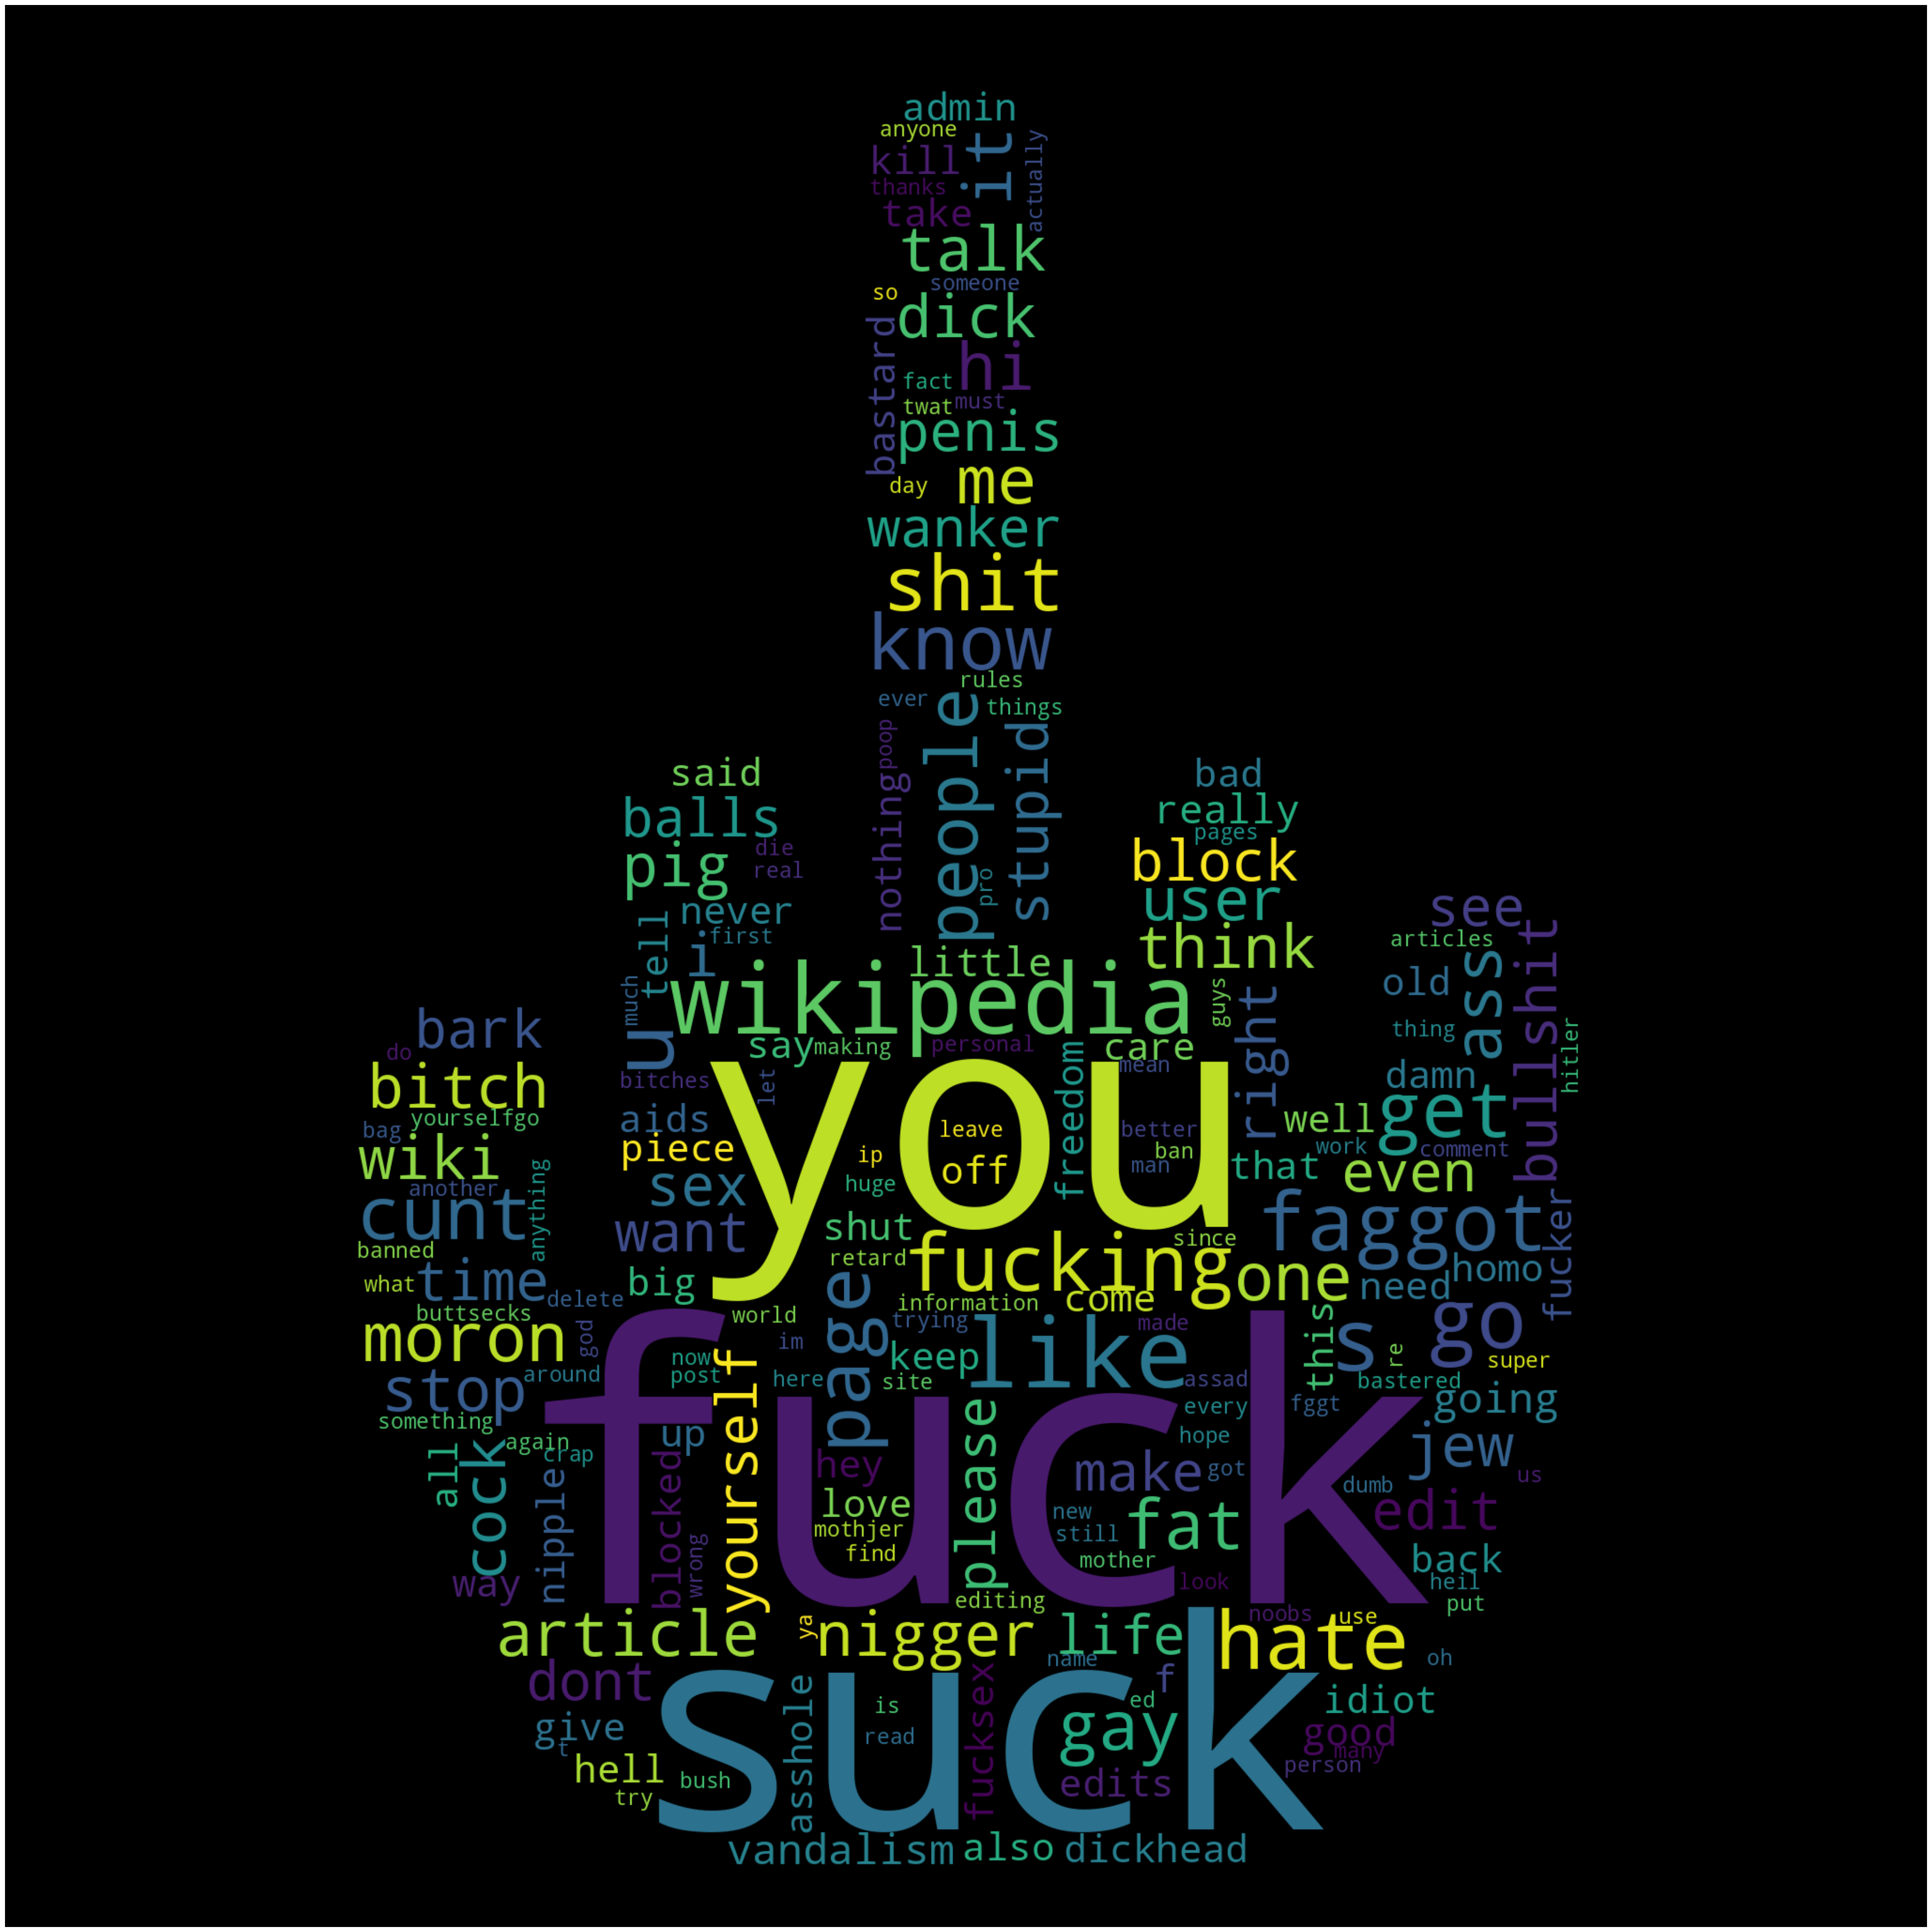

In [ ]:
plt.figure(figsize=(50, 50))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Random forest - Julia



Klasyfikacja bez względu na zbalansowanie klas:

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

rf_classifier = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
rf_classifier.fit(X_train, y_train)


y_pred = rf_classifier.predict(X_test)


'''
print("Example Predictions:")
for i in range(len(X_test)):
    print(f"Actual Labels: {y_test[i]}, Predicted Labels: {y_pred[i]}")
    '''

accuracy = accuracy_score(y_test, y_pred)



print(f'\nAccuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))




Accuracy: 0.90
              precision    recall  f1-score   support

           0       0.68      0.52      0.59      6089
           1       0.31      0.15      0.20       367
           2       0.77      0.47      0.58      3689
           3       0.46      0.03      0.05       211
           4       0.71      0.40      0.51      3426
           5       0.64      0.10      0.17       711

   micro avg       0.70      0.44      0.54     14493
   macro avg       0.59      0.28      0.35     14493
weighted avg       0.70      0.44      0.53     14493
 samples avg       0.05      0.04      0.04     14493



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


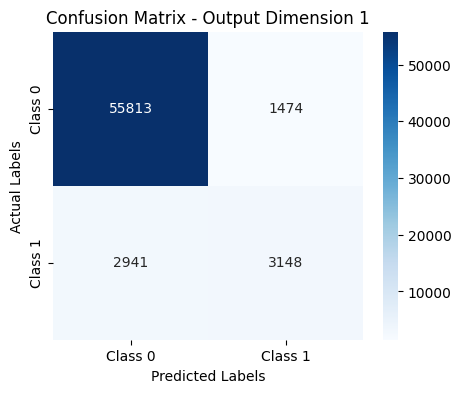

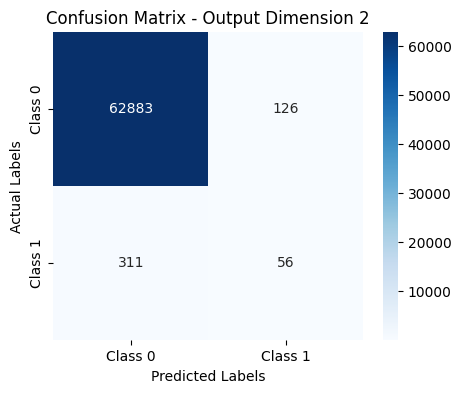

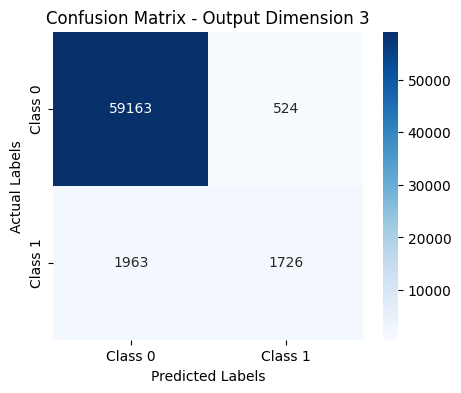

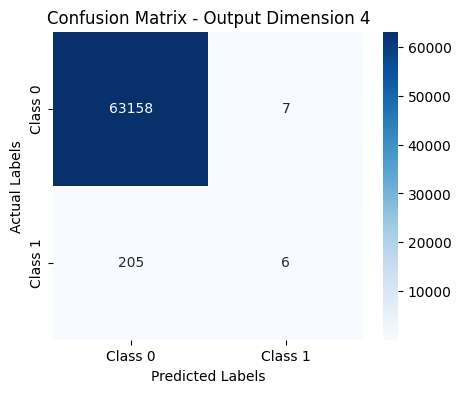

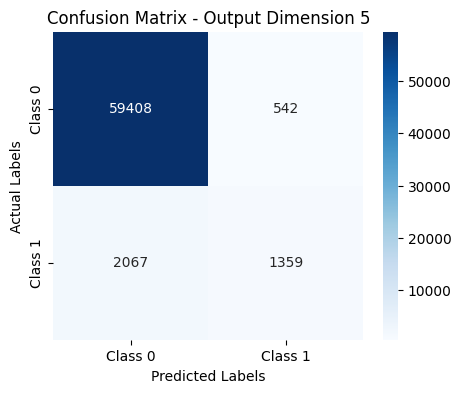

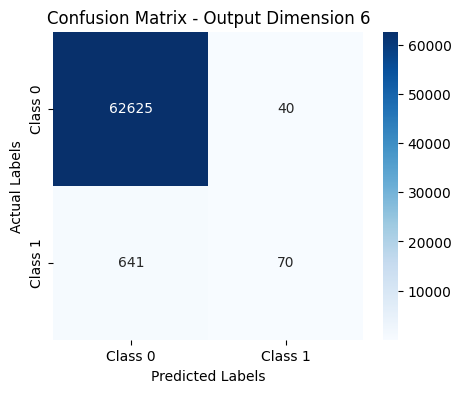

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate confusion matrix for each output dimension
conf_matrix_list = multilabel_confusion_matrix(y_test, y_pred)

# Plot confusion matrix for each output dimension
for i, conf_matrix in enumerate(conf_matrix_list):
    labels = [f'Class {j}' for j in range(conf_matrix.shape[0])]
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - Output Dimension {i+1}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.show()


Klasyfikacja w obrębie klas toksyczności (bez clean):

In [ ]:
indices_zero= [index for index, sublist in enumerate(y_test) if sum(sublist) == 0]
X_test2 = [value for index, value in enumerate(X_test) if index not in indices_zero]
y_test2= [value for index, value in enumerate(y_test) if index not in indices_zero]
indices_zero2= [index for index, sublist in enumerate(y_train) if sum(sublist) == 0]
X_train2 = [value for index, value in enumerate(X_train) if index not in indices_zero2]
y_train2= [value for index, value in enumerate(y_train) if index not in indices_zero2]

print(len(X_train2), len(y_train2), len(X_test2), len(y_test2))


16225 16225 6241 6241


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
rf_classifier = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
rf_classifier.fit(X_train2, y_train2)


y_pred2 = rf_classifier.predict(X_test2)


'''
print("Example Predictions:")
for i in range(len(X_test)):
    print(f"Actual Labels: {y_test[i]}, Predicted Labels: {y_pred[i]}")
    '''

accuracy = accuracy_score(y_test2, y_pred2)


print(f'\nAccuracy: {accuracy:.2f}')
print(classification_report(y_test2, y_pred2))


Accuracy: 0.39
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6089
           1       0.30      0.14      0.19       367
           2       0.80      0.67      0.73      3689
           3       0.58      0.03      0.06       211
           4       0.74      0.57      0.64      3426
           5       0.78      0.13      0.23       711

   micro avg       0.87      0.73      0.80     14493
   macro avg       0.70      0.42      0.47     14493
weighted avg       0.84      0.73      0.77     14493
 samples avg       0.89      0.78      0.79     14493



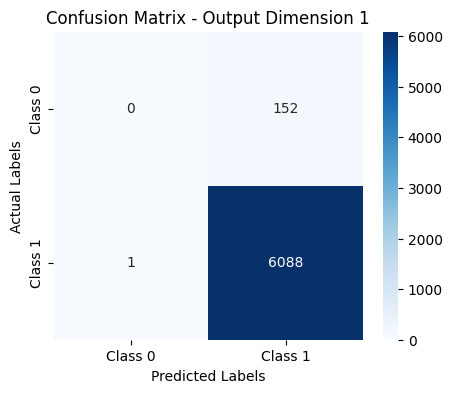

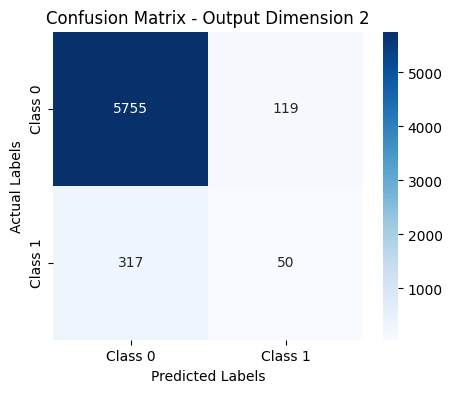

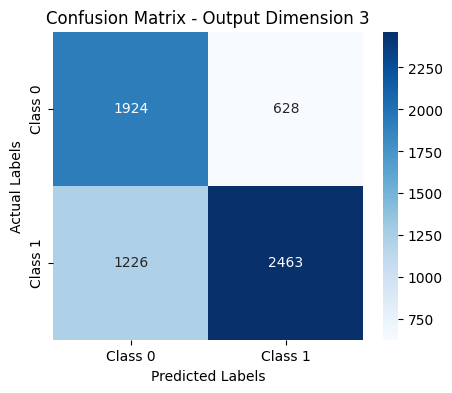

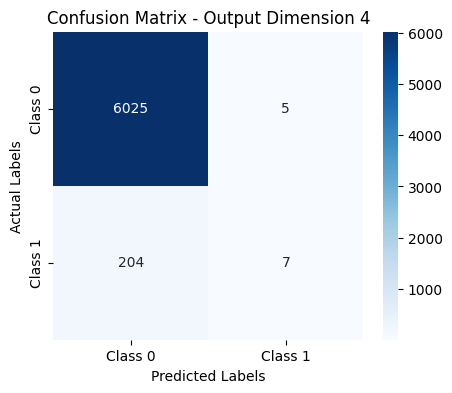

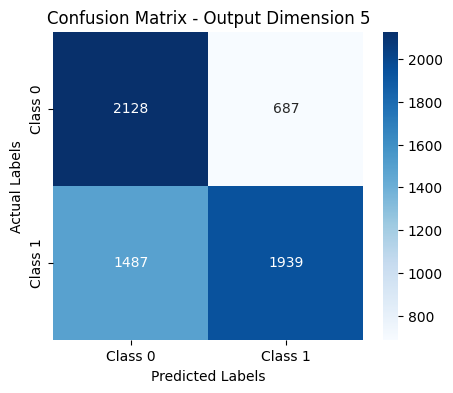

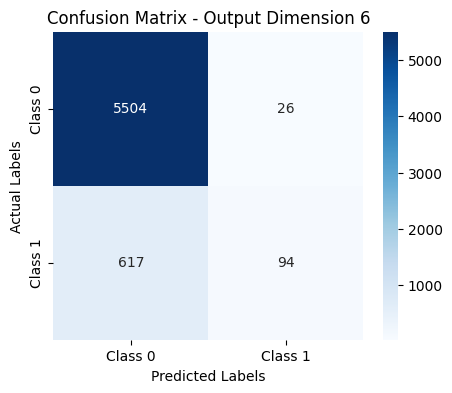

In [ ]:

conf_matrix_list = multilabel_confusion_matrix(y_test2, y_pred2)

for i, conf_matrix in enumerate(conf_matrix_list):
    labels = [f'Class {j}' for j in range(conf_matrix.shape[0])]
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - Output Dimension {i+1}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.show()

Próba dodania wag, by radzić sobie z niezbalansowanymi klasami:

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import class_weight

X_train2 = np.array(X_train2)
y_train2 = np.array(y_train2)
X_test2 = np.array(X_test2)
y_test2 = np.array(y_test2)

y_train2_tuples = [tuple(arr) for arr in y_train2]

class_weights = class_weight.compute_sample_weight('balanced', y_train2_tuples)

rf_classifier = MultiOutputClassifier(
    RandomForestClassifier(n_estimators=100, random_state=42),
    n_jobs=-1
)

rf_classifier.fit(X_train2, y_train2, sample_weight=class_weights)

y_pred2 = rf_classifier.predict(X_test2)

accuracy = accuracy_score(y_test2, y_pred2)

print(f'\nAccuracy: {accuracy:.2f}')
print(classification_report(y_test2, y_pred2))



Accuracy: 0.39
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6089
           1       0.36      0.18      0.24       367
           2       0.81      0.63      0.71      3689
           3       0.64      0.04      0.08       211
           4       0.76      0.52      0.62      3426
           5       0.72      0.10      0.17       711

   micro avg       0.88      0.71      0.79     14493
   macro avg       0.71      0.41      0.47     14493
weighted avg       0.85      0.71      0.76     14493
 samples avg       0.90      0.76      0.78     14493



II sposób obliczania wag:

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
from sklearn.multioutput import MultiOutputClassifier


X_train2 = np.array(X_train2)
y_train2 = np.array(y_train2)
X_test2 = np.array(X_test2)
y_test2 = np.array(y_test2)



rf_classifier = MultiOutputClassifier(
    RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),  # Using 'balanced' directly
    n_jobs=-1
)


rf_classifier.fit(X_train2, y_train2)


y_pred2 = rf_classifier.predict(X_test2)


accuracy = accuracy_score(y_test2, y_pred2)


print(f'\nAccuracy: {accuracy:.2f}')
print(classification_report(y_test2, y_pred2))



Accuracy: 0.39
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6089
           1       0.36      0.22      0.27       367
           2       0.78      0.67      0.73      3689
           3       0.62      0.08      0.14       211
           4       0.74      0.56      0.64      3426
           5       0.78      0.17      0.28       711

   micro avg       0.86      0.74      0.80     14493
   macro avg       0.71      0.45      0.51     14493
weighted avg       0.84      0.74      0.77     14493
 samples avg       0.89      0.78      0.79     14493



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Klasyfikacja binarna (clean/toxic) ze sztucznie wyrównanymi zbiorami, by zawierały identyczną liczbę toksycznych i czystych komentarzy

In [ ]:
y_test3 = [1 if sum(sublist) > 0 else 0 for sublist in y_test]
y_train3 = [1 if sum(sublist) > 0 else 0 for sublist in y_train]

clean_idx = [i for i in range(len(y_test3)) if y_test3[i] == 1]
toxic_idx = [i for i in range(len(y_test3)) if y_test3[i] == 0][:len(clean_idx)]
indx = clean_idx + toxic_idx

clean_idx2 = [i for i in range(len(y_train3)) if y_train3[i] == 1]
toxic_idx2 = [i for i in range(len(y_train3)) if y_train3[i] == 0][:len(clean_idx2)]
indx2 = clean_idx2 + toxic_idx2

y_test3 = [y_test3[i] for i in range(len(y_test3)) if i in indx]
X_test3 = [X_test[i] for i in range(len(X_test)) if i in indx]
y_train3 = [y_train3[i] for i in range(len(y_train3)) if i in indx2]
X_train3 = [X_train[i] for i in range(len(X_train)) if i in indx2]

print(len(X_train3), len(y_train3), len(X_test3), len(y_test3))
print(sum(y_train3)/len(y_train3), sum(y_test3)/len(y_test3))


32450 32450 12482 12482
0.5 0.5


In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train3, y_train3)


y_pred3 = rf_classifier.predict(X_test3)


#precision, recall, f1score,
#metody dla niezbalansowanych klas, batche
#print("Example Predictions:")
#for i in range(len(X_test3)):
    #if(i%10):
     # print(f"Actual Labels: {y_test3[i]}, Predicted Labels: {y_pred3[i]}")


accuracy = accuracy_score(y_test3, y_pred3)


print(f'\nAccuracy: {accuracy:.2f}')
print(classification_report(y_test3, y_pred3))


Accuracy: 0.84
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      6241
           1       0.84      0.86      0.85      6241

    accuracy                           0.84     12482
   macro avg       0.85      0.84      0.84     12482
weighted avg       0.85      0.84      0.84     12482



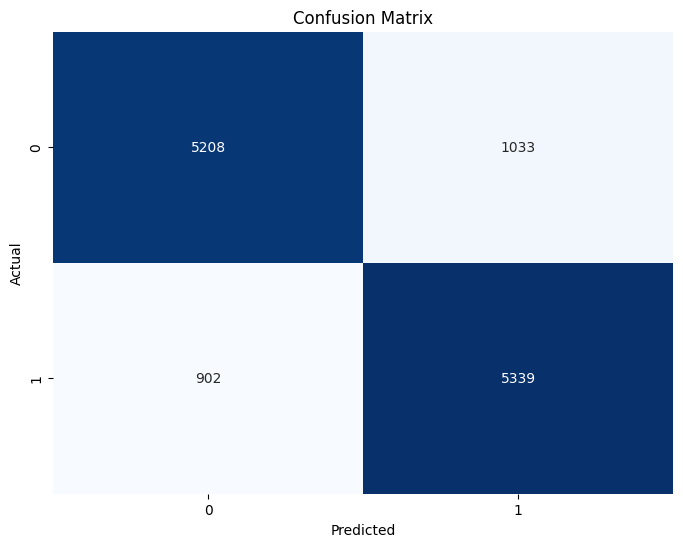

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test3, y_pred3)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Klasyfikacja binarna, ale z atrybutem  "balanced" i wejściowymi proporcjami klas toxic i clean


Accuracy: 0.93
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     57135
           1       0.68      0.49      0.57      6241

    accuracy                           0.93     63376
   macro avg       0.81      0.73      0.76     63376
weighted avg       0.92      0.93      0.92     63376



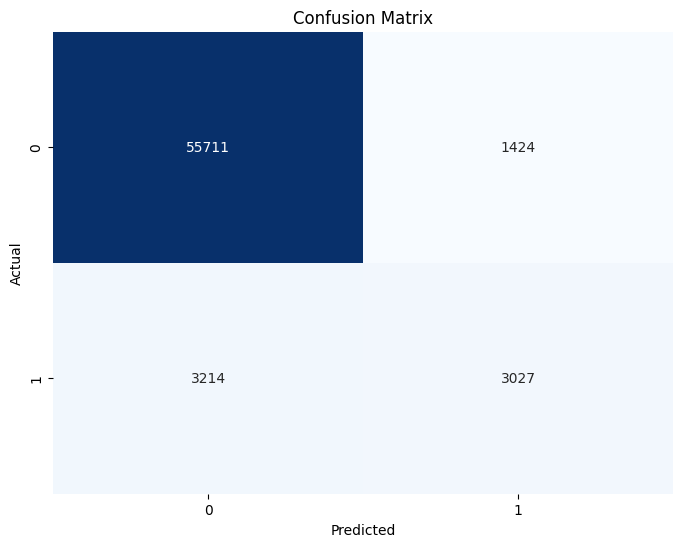

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
from sklearn.multioutput import MultiOutputClassifier



X_train3 = np.array(X_train3)
y_train3 = np.array(y_train3)
X_test3 = np.array(X_test3)
y_test3 = np.array(y_test3)

X_test3=X_test
X_train3=X_train

y_test3 = [1 if sum(sublist) > 0 else 0 for sublist in y_test]
y_train3 = [1 if sum(sublist) > 0 else 0 for sublist in y_train]


rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

rf_classifier.fit(X_train3, y_train3)

y_pred3 = rf_classifier.predict(X_test3)

accuracy = accuracy_score(y_test3, y_pred3)

print(f'\nAccuracy: {accuracy:.2f}')
print(classification_report(y_test3, y_pred3))

cm = confusion_matrix(y_test3, y_pred3)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



Accuracy: 0.93
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     57135
           1       0.67      0.53      0.59      6241

    accuracy                           0.93     63376
   macro avg       0.81      0.75      0.78     63376
weighted avg       0.92      0.93      0.92     63376



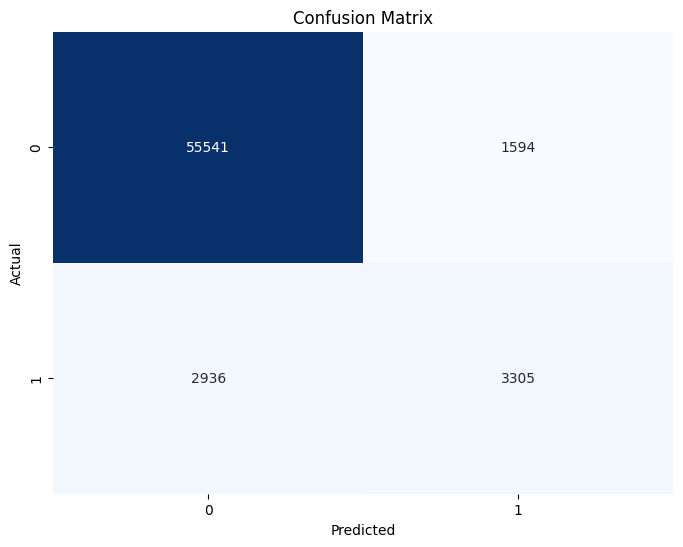

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
from sklearn.multioutput import MultiOutputClassifier



X_train3 = np.array(X_train3)
y_train3 = np.array(y_train3)
X_test3 = np.array(X_test3)
y_test3 = np.array(y_test3)

X_test3=X_test
X_train3=X_train

y_test3 = [1 if sum(sublist) > 0 else 0 for sublist in y_test]
y_train3 = [1 if sum(sublist) > 0 else 0 for sublist in y_train]


rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X_train3, y_train3)

y_pred3 = rf_classifier.predict(X_test3)

accuracy = accuracy_score(y_test3, y_pred3)

print(f'\nAccuracy: {accuracy:.2f}')
print(classification_report(y_test3, y_pred3))

cm = confusion_matrix(y_test3, y_pred3)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# KNN Szymon


## Data preprocessing

In [ ]:
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [ ]:
# data preprocessing - normalization
knn_x_train = np.array(X_train)
knn_y_train = np.array(y_train)
knn_x_test = np.array(X_test)
knn_y_test = np.array(y_test)
print(knn_x_train[0])
print(knn_y_train[0])
print(knn_x_test[0])
print(knn_y_test[0])

knn_x_train_normalized = normalize(knn_x_train)
knn_x_test_normalized = normalize(knn_x_test)
print(knn_x_train_normalized[0])
print(knn_x_test_normalized[0])

[ 0.13367681 -0.49249983 -0.23989058  0.272511    0.0645669  -0.59128624
  0.30820617  1.4724779   0.3543795  -0.05818273  0.53266674 -0.30546764
  0.32293555 -0.41187787 -0.13495296 -0.38561872 -0.2897159  -1.0736367
 -0.7524104  -0.5197564   0.18317086  0.07973403  0.6466847   0.2573358
 -0.5377054   0.01261659 -0.27241084 -0.43563262 -0.67887217  0.3135278
 -0.3079852  -0.1268864   0.6318148   0.21198525 -0.3016768   0.576212
 -0.2545189  -0.95454717 -0.84223133 -0.807386    0.26693976 -0.24802856
  0.38763198 -0.34287035  0.5143112  -0.04237759 -0.9267822  -0.22395079
  0.66740555  0.31759238  0.36096287 -0.51211935  0.45924017 -0.03723373
 -0.1548958  -0.3744124  -0.49010757  0.5717513  -0.5422916   0.14877367
  0.09646932  0.27326146 -0.07310633 -0.3522601  -0.6190747  -0.1339742
  0.38978633  0.15966377 -0.656448    0.56387275 -0.8886401  -0.08410273
  0.94065076 -0.721401   -0.37930968  0.34689677  0.6426203  -0.22771026
  0.11968958 -0.04622748 -0.877832    0.03327958 -0.43832

## Unbalanced dataset - clean and toxic comments

In [ ]:
ks = np.arange(1, 30, 2)

accuracies = {}

for normalized in [True, False]:
    for k in ks:
        knn_classifier = KNeighborsClassifier(n_neighbors=k)
        if normalized:
            knn_model=knn_classifier.fit(knn_x_train_normalized, knn_y_train)
            knn_y_prediction=knn_model.predict(knn_x_test_normalized)
            accuracies[(k, normalized)] = accuracy_score(knn_y_test, knn_y_prediction)
        else:
            knn_model=knn_classifier.fit(knn_x_train, knn_y_train)
            knn_y_prediction=knn_model.predict(knn_x_test)
            accuracies[(k, normalized)] = accuracy_score(knn_y_test, knn_y_prediction)

print(accuracies)

max_accuracy_params = max(accuracies, key=accuracies.get)
print("Max accuracy parameters [k, normalized]: ", max_accuracy_params)
print("Accuracy: ", accuracies[max_accuracy_params])

In [ ]:
print("Classification report")
knn_classifier = KNeighborsClassifier(n_neighbors=57)
knn_model=knn_classifier.fit(knn_x_train, knn_y_train)
knn_y_prediction=knn_model.predict(knn_x_test)
print(classification_report(knn_y_test, knn_y_prediction))
print("Accuracy: ", accuracy_score(knn_y_test, knn_y_prediction))

Classification report
              precision    recall  f1-score   support

           0       0.65      0.54      0.59      6089
           1       0.29      0.21      0.24       367
           2       0.66      0.54      0.59      3689
           3       0.67      0.01      0.02       211
           4       0.59      0.49      0.54      3426
           5       0.61      0.10      0.17       711

   micro avg       0.63      0.49      0.55     14493
   macro avg       0.58      0.32      0.36     14493
weighted avg       0.63      0.49      0.54     14493
 samples avg       0.05      0.04      0.04     14493

Accuracy:  0.8932561221913659


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Notes
# Accuracy results for odd ks in range [1, 29], features normalized and not normalized

# (1, True): 0.8051937838177928         (1, False): 0.8371083427708569
# (3, True): 0.8815118912797282         (3, False): 0.8918931672329181
# (5, True): 0.885223983893293          (5, False): 0.89920724801812
# (7, True): 0.8881653454133636         (7, False): 0.8998364162577073
# (9, True): 0.8910123316974959         (9, False): 0.8998049578457279
# (11, True): 0.8926638983264125        (11, False): 0.90019818799547
# (13, True): 0.8936391090977728        (13, False): 0.9004813137032842
# (15, True): 0.893922234805587         (15, False): 0.9005756889392224
# (17, True): 0.8942525481313703        (17, False): 0.9008116270290676
# (19, True): 0.8940952560714736        (19, False): 0.9010947527368819
# (21, True): 0.8940952560714736        (21, False): 0.9011891279728199
# (23, True): 0.8940637976594942        (23, False): 0.9013149616207374
# (25, True): 0.8943154649553291        (25, False): 0.9014250660626651
# (27, True): 0.8943154649553291        (27, False): 0.9015037120926136
# (29, True): 0.8945356738391846        (29, False): 0.9015194412986033

# Normalization seems to worsen the results??
# Best accuracy for ks in range [1, 60], not normalized:
# Max accuracy parameters [k, normalized]:  (57, False)
# Accuracy:  0.9017711085944381

# TODO
# Balance the dataset

In [ ]:
# Testing the performance with some very nice little comments
my_toxic_comments = ["shut the fuck up bitch motherfucker",
                     "i hope you will stop sharing such stupid beliefs with us you moron. that would make me very happy",
                     "i hope you will stop sharing such idiotic beliefs with us",
                     "i swear i will kill you if you don't stop posting that",
                     "i hate jews and niggers",
                     "i think your work is fucking amazing!"] # It is obscene, but is it toxic?
my_toxic_comments_clean = preprocessing(pd.Series(my_toxic_comments))
print(my_toxic_comments_clean[0])

my_toxic_comments_word2vec = []
for word_list in my_toxic_comments_clean:
    word_vectors = [model.wv[word] for word in word_list if word in model.wv]
    mean_vector = np.mean(word_vectors, axis=0)
    my_toxic_comments_word2vec.append(mean_vector)

my_non_toxic_comments = ["amazing job, keep it up <3",
                         "i think your work is absolutely amazing!",
                         "i love your content, but it got a little boring lately tbh"]
my_non_toxic_comments_clean = preprocessing(pd.Series(my_non_toxic_comments))
print(my_non_toxic_comments_clean[0])

my_non_toxic_comments_word2vec = []
for word_list in my_non_toxic_comments_clean:
    word_vectors = [model.wv[word] for word in word_list if word in model.wv]
    mean_vector = np.mean(word_vectors, axis=0)
    my_non_toxic_comments_word2vec.append(mean_vector)

['shut', 'fuck', 'bitch', 'motherfucker']
['amazing', 'job', 'keep']


In [ ]:
my_toxic_comments_prediction=knn_model.predict(my_toxic_comments_word2vec)
print(my_toxic_comments_prediction)

[[1 1 1 0 1 0]
 [1 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 1 0 1 1]
 [1 0 1 0 1 0]]


In [ ]:
my_non_toxic_comments_prediction=knn_model.predict(my_non_toxic_comments_word2vec)
print(my_non_toxic_comments_prediction)

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


## Balancing set - only toxic comments

In [ ]:
# Getting rid of non-toxic comments (there are so many more clean comments than toxic ones that the risk of classifying everyting as clean and getting a good result is too high)
knn_test_indices_zero = [index for index, sublist in enumerate(y_test) if sum(sublist) == 0]
knn_x_test_toxic = [value for index, value in enumerate(X_test) if index not in knn_test_indices_zero]
knn_y_test_toxic = [value for index, value in enumerate(y_test) if index not in knn_test_indices_zero]
knn_train_indices_zero = [index for index, sublist in enumerate(y_train) if sum(sublist) == 0]
knn_x_train_toxic = [value for index, value in enumerate(X_train) if index not in knn_train_indices_zero]
knn_y_train_toxic = [value for index, value in enumerate(y_train) if index not in knn_train_indices_zero]

print(len(knn_x_test_toxic), len(knn_y_test_toxic), len(knn_x_train_toxic), len(knn_y_train_toxic))

6241 6241 16225 16225


In [ ]:
ks = np.arange(1, 100, 2)

accuracies = {}

for k in ks:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_model=knn_classifier.fit(knn_x_train_toxic, knn_y_train_toxic)
    knn_y_prediction=knn_model.predict(knn_x_test_toxic)
    accuracies[k] = accuracy_score(knn_y_test_toxic, knn_y_prediction)

print(accuracies)

max_accuracy_k = max(accuracies, key=accuracies.get)
print("Max accuracy k: ", max_accuracy_k)
print("Accuracy: ", accuracies[max_accuracy_k])

{1: 0.27014901458099666, 3: 0.3177375420605672, 5: 0.3360038455375741, 7: 0.3501041499759654, 9: 0.35378945681781765, 11: 0.3573145329274155, 13: 0.3621214548950489, 15: 0.3627623778240667, 17: 0.3613203012337766, 19: 0.3608396090370133, 21: 0.36244191635955775, 23: 0.3608396090370133, 25: 0.36564653100464667, 27: 0.36324307002083, 29: 0.36180099343053995, 31: 0.36372376221759334, 33: 0.36484537734337447, 35: 0.36885114564973565, 37: 0.36756929979170005, 39: 0.3659669924691556, 41: 0.36885114564973565, 43: 0.3666079153981734, 45: 0.3670886075949367, 47: 0.3677295305239545, 49: 0.369331837846499, 51: 0.36885114564973565, 53: 0.3698125300432623, 55: 0.3701329915077712, 57: 0.3699727607755167, 59: 0.37109437590129785, 61: 0.36901137638199005, 63: 0.3698125300432623, 65: 0.36901137638199005, 67: 0.369331837846499, 69: 0.37029322224002564, 71: 0.37093414516904344, 73: 0.37237622175933344, 75: 0.372215991027079, 77: 0.3701329915077712, 79: 0.3726966832238423, 81: 0.37285691395609677, 83: 0.3

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=77)
knn_model=knn_classifier.fit(knn_x_train_toxic, knn_y_train_toxic)
knn_y_prediction=knn_model.predict(knn_x_test_toxic)

In [ ]:
knn_y_prediction[:10]

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0]])

In [ ]:
# Notes
# I tested every odd k in range [1,100] and got ~38% accuracy with k=77
# There are 5 toxicity categories and some comments belong to more than one of them, so 38% may seem like a poor result, but it's definitely better than random

In [ ]:
my_toxic_comments_prediction=knn_model.predict(my_toxic_comments_word2vec)
print(my_toxic_comments_prediction)

[[1 1 1 0 1 0]
 [1 0 1 0 1 0]
 [1 0 0 0 1 0]
 [1 0 1 0 1 0]
 [1 0 1 0 1 1]
 [1 0 1 0 1 0]]


## Balancing toxicity classes in toxic comments dataset

<ipython-input-72-9835eea4a90f>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=knn_label_counts.values,


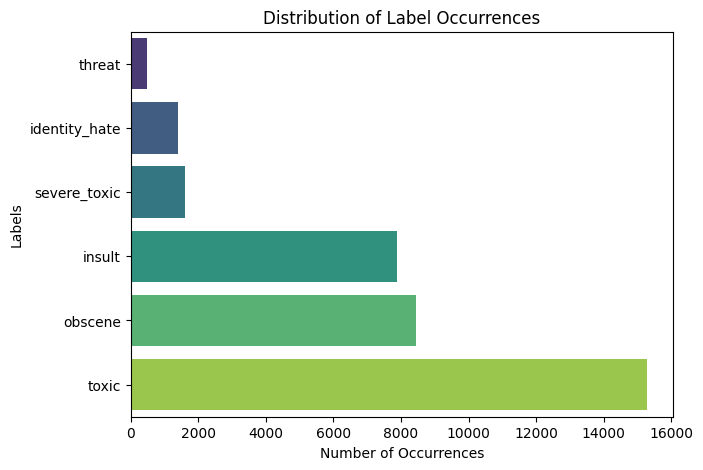

In [ ]:
# The amount of elements in each of the toxicity classes still varies a lot. The distribution in the knn_y_train_toxic list is depicted on the below diagram.
# I will try to make up for these differences by introducing oversampling.

# Visualizing the class distribution of the 'label' column
knn_column_labels = train.columns.tolist()[2:]
knn_toxic_train_dataframe = pd.DataFrame(knn_y_train_toxic, columns = knn_column_labels)
knn_label_counts = knn_toxic_train_dataframe[knn_column_labels].sum().sort_values()


# Create a black background for the plot
plt.figure(figsize=(7, 5))

# Create a horizontal bar plot using Seaborn
ax = sns.barplot(x=knn_label_counts.values,
                 y=knn_label_counts.index, palette='viridis')


# Add labels and title to the plot
plt.xlabel('Number of Occurrences')
plt.ylabel('Labels')
plt.title('Distribution of Label Occurrences')

# Show the plot
plt.show()

In [ ]:
from collections import defaultdict
vector_list_tuples = [tuple(vector) for vector in knn_y_train_toxic]
vector_counts = defaultdict(int)
for vector in vector_list_tuples:
    vector_counts[vector] += 1

vector_counts_list = list(vector_counts.items())
vector_counts_list_sorted = sorted(vector_counts_list, key=lambda x: x[1], reverse=True)

for vector, count in vector_counts_list_sorted:
    print(f"{vector}: {count}")

(1, 0, 0, 0, 0, 0): 5666
(1, 0, 1, 0, 1, 0): 3800
(1, 0, 1, 0, 0, 0): 1758
(1, 0, 0, 0, 1, 0): 1215
(1, 1, 1, 0, 1, 0): 989
(1, 0, 1, 0, 1, 1): 618
(0, 0, 1, 0, 0, 0): 317
(0, 0, 0, 0, 1, 0): 301
(1, 1, 1, 0, 1, 1): 265
(0, 0, 1, 0, 1, 0): 181
(1, 1, 1, 0, 0, 0): 158
(1, 0, 0, 0, 0, 1): 136
(1, 0, 0, 0, 1, 1): 134
(1, 0, 1, 1, 1, 0): 131
(1, 0, 0, 1, 0, 0): 113
(1, 1, 1, 1, 1, 0): 64
(1, 0, 1, 1, 1, 1): 56
(0, 0, 0, 0, 0, 1): 54
(1, 1, 0, 0, 0, 0): 41
(1, 0, 1, 0, 0, 1): 35
(1, 1, 1, 1, 1, 1): 31
(0, 0, 0, 0, 1, 1): 28
(0, 0, 0, 1, 0, 0): 22
(0, 0, 1, 0, 1, 1): 18
(1, 0, 0, 1, 1, 0): 16
(1, 1, 0, 0, 1, 0): 14
(1, 0, 1, 1, 0, 0): 11
(1, 1, 0, 1, 0, 0): 11
(1, 1, 0, 0, 1, 1): 7
(1, 0, 0, 1, 0, 1): 7
(1, 1, 1, 0, 0, 1): 6
(1, 1, 1, 1, 0, 0): 4
(1, 1, 0, 0, 0, 1): 3
(0, 0, 0, 1, 1, 0): 3
(1, 0, 0, 1, 1, 1): 3
(0, 0, 1, 0, 0, 1): 3
(0, 0, 1, 1, 0, 0): 2
(0, 0, 1, 1, 1, 0): 2
(1, 1, 0, 1, 1, 0): 1
(1, 1, 0, 1, 0, 1): 1


<ipython-input-74-4fe74b985d7e>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=knn_label_counts.values,


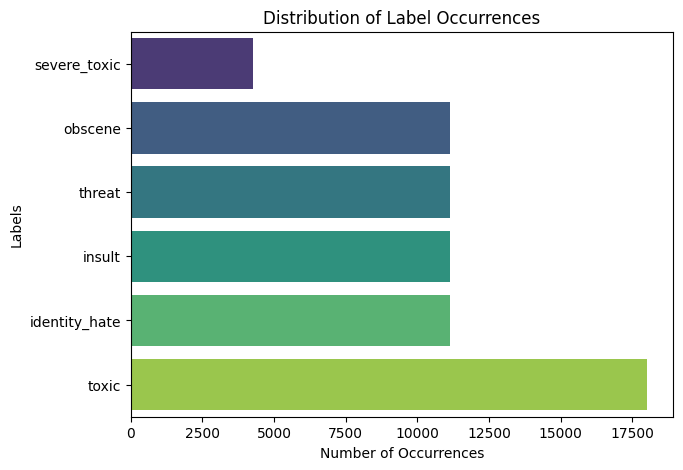

In [ ]:
train_upsampled = pd.read_csv('/content/drive/MyDrive/kaggle/upsampled.csv')

# Visualizing the class distribution of the 'label' column
knn_column_labels = train_upsampled.columns.tolist()[1:]
knn_label_counts = train_upsampled[knn_column_labels].sum().sort_values()


# Create a black background for the plot
plt.figure(figsize=(7, 5))

# Create a horizontal bar plot using Seaborn
ax = sns.barplot(x=knn_label_counts.values,
                 y=knn_label_counts.index, palette='viridis')


# Add labels and title to the plot
plt.xlabel('Number of Occurrences')
plt.ylabel('Labels')
plt.title('Distribution of Label Occurrences')

# Show the plot
plt.show()

In [ ]:
knn_train_prepared=preprocessing(train_upsampled['comment_text'])
knn_upsampled_y_train = train_upsampled.filter(items=column_labels).values.tolist()

knn_upsampled_x_train = []
for word_list in knn_train_prepared:
    word_vectors = [model.wv[word] for word in word_list if word in model.wv]
    mean_vector = np.mean(word_vectors, axis=0)
    knn_upsampled_x_train.append(mean_vector)

knn_classifier = KNeighborsClassifier(n_neighbors=25)
knn_model=knn_classifier.fit(knn_upsampled_x_train, knn_upsampled_y_train)
knn_y_prediction=knn_model.predict(knn_x_test_toxic)
accuracy = accuracy_score(knn_y_test_toxic, knn_y_prediction)
print(accuracy)

0.30475885274795705


In [ ]:
knn_train_prepared=preprocessing(train_upsampled['comment_text'])
print(knn_train_prepared[0])

knn_upsampled_y_train = train_upsampled.filter(items=column_labels).values.tolist()
knn_upsampled_y_train[0]

['cock', 'suck', 'piss', 'around', 'work']


[1, 1, 1, 0, 1, 0]

In [ ]:
toxic_test_idx = [index for index, sublist in enumerate(y_test) if any(element == 1 for element in sublist)]
knn_test_prepared = [test_prepared[index] for index in toxic_test_idx]
knn_upsampled_y_test = [y_test[index] for index in toxic_test_idx]
print(len(knn_test_prepared))
print(len(knn_upsampled_y_test))

6241
6241


In [ ]:
knn_word2vec_model = Word2Vec(sentences=knn_train_prepared+knn_test_prepared, vector_size=100, window=5, min_count=1, workers=4)

knn_upsampled_x_train = []
for word_list in knn_train_prepared:
    word_vectors = [knn_word2vec_model.wv[word] for word in word_list if word in knn_word2vec_model.wv]
    mean_vector = np.mean(word_vectors, axis=0)
    knn_upsampled_x_train.append(mean_vector)

knn_upsampled_x_test = []
idx_to_remove = []
for i, word_list in enumerate(knn_test_prepared):
    word_vectors = [knn_word2vec_model.wv[word] for word in word_list if word in knn_word2vec_model.wv]
    if (len(word_vectors) != 0):
        mean_vector = np.mean(word_vectors, axis=0)
        knn_upsampled_x_test.append(mean_vector)
    else:
        idx_to_remove.append(i)
for i in reversed(idx_to_remove):
    knn_upsampled_y_test.pop(i)

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=25)
knn_model=knn_classifier.fit(knn_upsampled_x_train, knn_upsampled_y_train)
knn_y_prediction=knn_model.predict(knn_upsampled_x_test)
accuracy = accuracy_score(knn_upsampled_y_test, knn_y_prediction)
print(accuracy)

0.2327530625402966


### Upsampling code, performed locally

In [ ]:
train = pd.read_csv('project/data/train.csv')

train_toxic = train[train[column_labels].sum(axis=1) > 0]
train_toxic = train_toxic.drop(columns=['id'])
print(len(train_toxic))
train_toxic.head(10)

!pip install git+https://github.com/phiyodr/multilabel-oversampling

import multilabel_oversampling as mo

moer = mo.MultilabelOversampler(number_of_adds=len(train_toxic) * 2, number_of_tries=5000)
train_toxic_oversampled = moer.fit(df=train_toxic, target_list=column_labels)

train_toxic_oversampled.to_csv('project/data/upsampled.csv', index=False)

fig = plt.figure(figsize=(18, 6))
p = moer.plot_results()

FileNotFoundError: [Errno 2] No such file or directory: 'project/data/train.csv'

## Question - which words are the most common in each toxicity class? What are the words that describe each label best? How will a classifier using only these words perform? How many words are needed to achieve a resonable accuracy?

In [ ]:
knn_sentences = list_of_lists_of_words
print(len(knn_sentences))
knn_sentences = delete_idx(knn_sentences, faulty_idx)
print(len(knn_sentences))

159571
159549


In [ ]:
label_common_words = [dict() for _ in range(0, 6)]
sorted_label_common_words = {}
word_freq = {}

for label in range(0, 6):
    for sentence_i in range(0, len(knn_sentences)):
        if y_train[sentence_i][label] == 1:
            for word in knn_sentences[sentence_i]:
                if word in label_common_words[label]:
                    label_common_words[label][word] += 1
                else:
                    label_common_words[label][word] = 1
    sorted_label_common_words[label] = sorted(label_common_words[label], key=label_common_words[label].get, reverse=True)

['fuck', 'suck', 'you', 'shit', 'wikipedia', 'like', 'nigger', 'fucking', 'ass', 's', 'u', 'go', 'faggot', 'hate', 'cunt', 'gay', 'get', 'know', 'page', 'die']
['fuck', 'suck', 'ass', 'you', 'shit', 'u', 'faggot', 'fucking', 'go', 'cock', 'die', 'bitch', 'cunt', 'nigger', 'yourself', 'wikipedia', 'fucksex', 'yourselfgo', 'dick', 'kill']
['fuck', 'suck', 'shit', 'you', 'fucking', 'ass', 'nigger', 'u', 's', 'cunt', 'go', 'faggot', 'wikipedia', 'bitch', 'like', 'cock', 'get', 'fat', 'dick', 'penis']
['die', 'ass', 'you', 'kill', 'going', 'wikipedia', 'block', 'must', 'fuck', 'jim', 'wales', 'supertrll', 'fucking', 'ban', 'page', 'talk', 'murder', 'live', 'fuckin', 'rvv']
['fuck', 'suck', 'nigger', 'you', 'fucking', 'faggot', 'ass', 'u', 'go', 'cunt', 's', 'fat', 'shit', 'bitch', 'like', 'moron', 'wikipedia', 'hi', 'hate', 'jew']
['nigger', 'fat', 'jew', 'gay', 'fuck', 'die', 'faggot', 'cunt', 'suck', 'fucking', 'shit', 'huge', 'stupid', 'ass', 'like', 'mexicans', 'bitch', 'niggas', 's', '

In [ ]:
for label in range(0, 6):
    print(sorted_label_common_words[label][:20])

In [ ]:
label_counts = [0,0,0,0,0,0]
for label_list in y_train:
    for label in range(0, 6):
        if label_list[label] == 1:
            label_counts[label] += 1
label_counts

In [ ]:
all_words = set()
for sentence in knn_sentences:
    for word in sentence:
        all_words.add(word)

In [ ]:
label_characteristic_words = [dict() for _ in range(0, 6)]

for word in all_words:
    max_value = 0
    max_label = 0
    for label in range(0, 6):
        if word in label_common_words[label]:
            value = label_common_words[label][word] / label_counts[label]
            if value > max_value:
                max_value = value
                max_label = label
    label_characteristic_words[max_label][word] = max_value

In [ ]:
sorted_label_characteristic_words = {}
for label in range(0, 6):
    sorted_label_characteristic_words[label] = sorted(label_characteristic_words[label], key=label_characteristic_words[label].get, reverse=True)
    print(sorted_label_characteristic_words[label][:10])

# xgboost Kasia


## sampled

In [ ]:
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
xgby_train = np.array(new_y_train)
xgbX_train = np.array(new_X_train)
xgby_test = np.array(y_test)
xgbX_test = np.array(X_test)

In [ ]:
count_all_zeros = np.sum(np.all(xgby_train == 0, axis=1))
count_all_zeros

0

In [ ]:
indices_to_remove = np.where(np.all(xgby_test == 0, axis=1))[0]

In [ ]:
xgbX_test_filtered = np.delete(xgbX_test, indices_to_remove, axis=0)
xgby_test_filtered = np.delete(xgby_test, indices_to_remove, axis=0)
xgbX_test = xgbX_test_filtered
xgby_test = xgby_test_filtered

In [ ]:
count_all_zeros = np.sum(np.all(xgby_test == 0, axis=1))
count_all_zeros

0

In [ ]:
classifier = MultiOutputClassifier(XGBClassifier())

clf = Pipeline([('classify', classifier)])

clf.fit(xgbX_train, xgby_train)
print(clf.score(xgbX_train, xgby_train))

y_pred = clf.predict(xgbX_test)

0.9962576008844666


In [ ]:
accuracy_score(xgby_test, y_pred)

0.05447844896651178

In [ ]:
print(classification_report(xgby_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      6089
           1       0.04      0.02      0.02       367
           2       0.56      0.20      0.30      3689
           3       0.04      0.02      0.03       211
           4       0.53      0.61      0.57      3426
           5       0.10      0.61      0.17       711

   micro avg       0.58      0.64      0.61     14493
   macro avg       0.38      0.41      0.34     14493
weighted avg       0.69      0.64      0.63     14493
 samples avg       0.61      0.71      0.60     14493



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


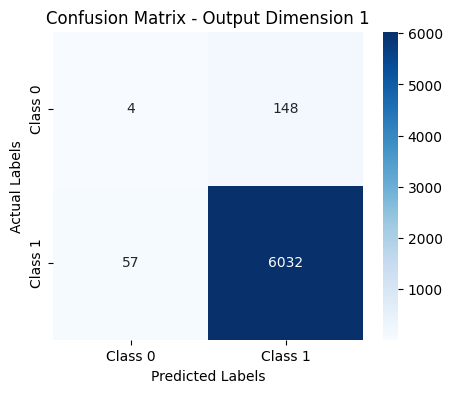

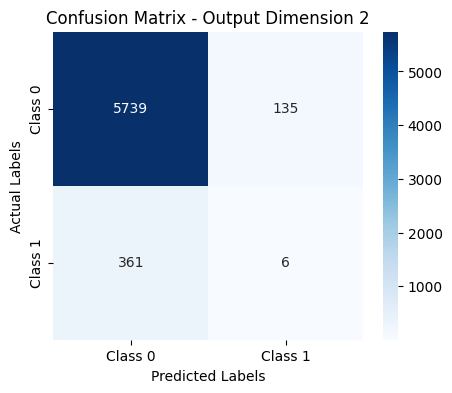

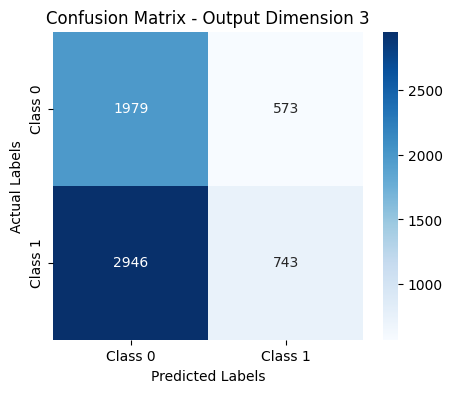

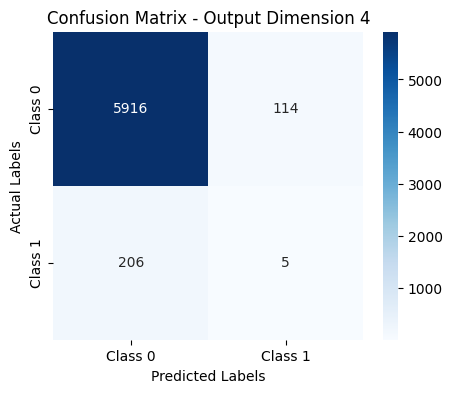

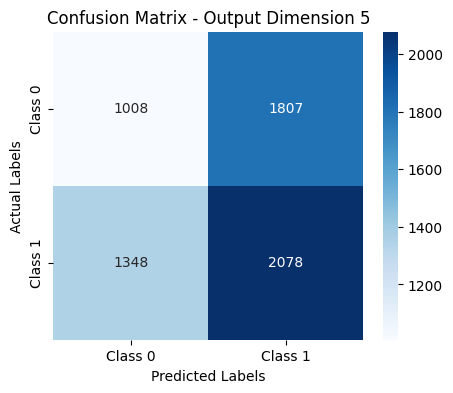

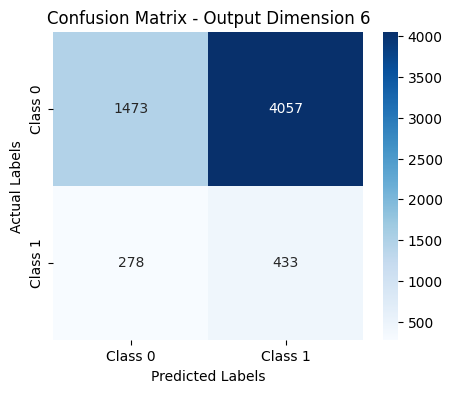

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
conf_matrix_list = multilabel_confusion_matrix(xgby_test, y_pred)

for i, conf_matrix in enumerate(conf_matrix_list):
    labels = [f'Class {j}' for j in range(conf_matrix.shape[0])]
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - Output Dimension {i+1}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.show()

## unbalanced

In [ ]:
xgby_train = np.array(y_train)
xgbX_train = np.array(X_train)
xgby_test = np.array(y_test)
xgbX_test = np.array(X_test)

In [ ]:
indices_to_remove = np.where(np.all(xgby_train == 0, axis=1))[0]
xgby_train = np.delete(xgby_train, indices_to_remove, axis=0)
xgbX_train = np.delete(xgbX_train, indices_to_remove, axis=0)
indices_to_remove = np.where(np.all(xgby_test == 0, axis=1))[0]
xgby_test = np.delete(xgby_test, indices_to_remove, axis=0)
xgbX_test = np.delete(xgbX_test, indices_to_remove, axis=0)

In [ ]:
classifier = MultiOutputClassifier(XGBClassifier())

clf = Pipeline([('classify', classifier)])

clf.fit(xgbX_train, xgby_train)
print(clf.score(xgbX_train, xgby_train))

y_pred = clf.predict(xgbX_test)

0.9617873651771957


In [ ]:
accuracy_score(xgby_test, y_pred)

0.3760615286011857

In [ ]:
print(classification_report(xgby_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6089
           1       0.31      0.26      0.28       367
           2       0.78      0.70      0.74      3689
           3       0.59      0.20      0.30       211
           4       0.71      0.62      0.66      3426
           5       0.66      0.29      0.40       711

   micro avg       0.84      0.77      0.80     14493
   macro avg       0.67      0.51      0.56     14493
weighted avg       0.82      0.77      0.79     14493
 samples avg       0.86      0.81      0.79     14493



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


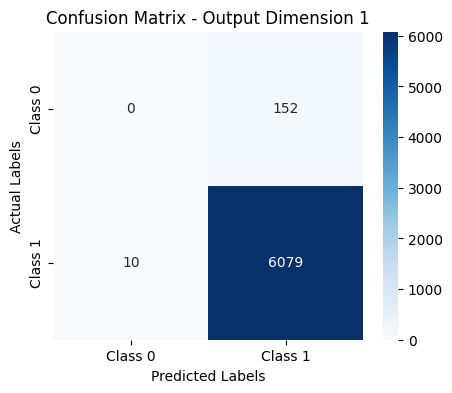

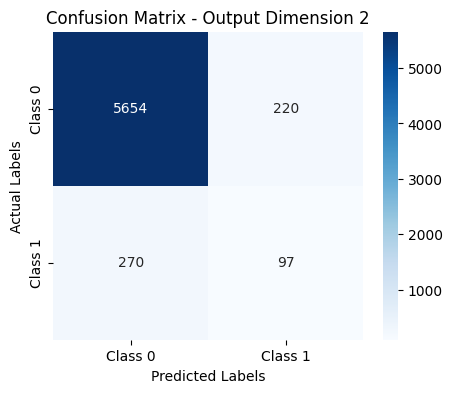

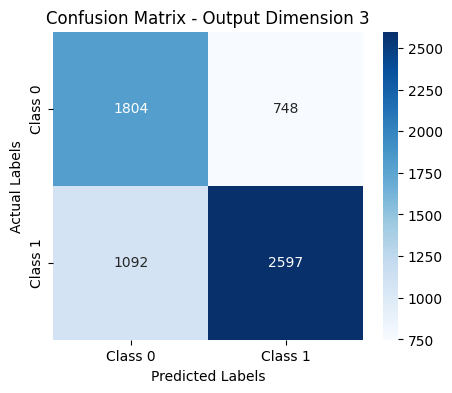

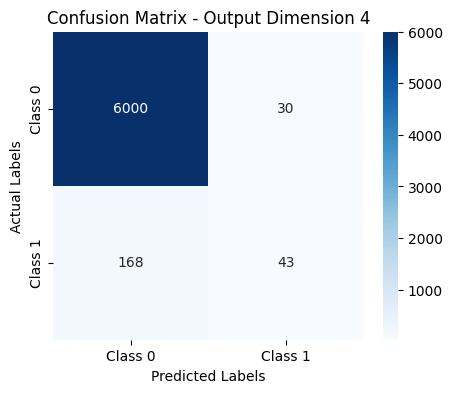

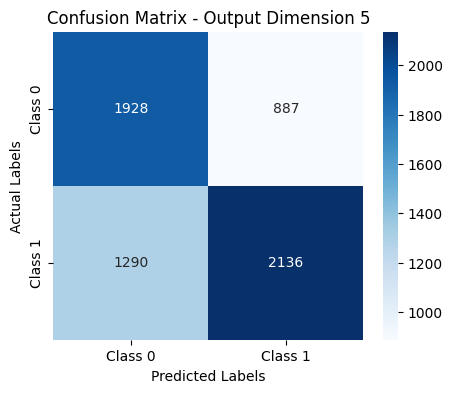

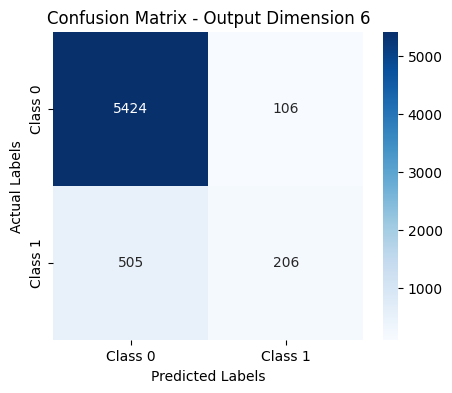

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
conf_matrix_list = multilabel_confusion_matrix(xgby_test, y_pred)

for i, conf_matrix in enumerate(conf_matrix_list):
    labels = [f'Class {j}' for j in range(conf_matrix.shape[0])]
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - Output Dimension {i+1}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.show()

# Questions

**Are toxic comments or words somehow similar to each other? Can we represent them in a way that is more understandable for a computer than plain text?**

In our project, we used a Word2Vec model that allows us to convert ordinary words as well as sentences into their vector representation.

We used 100-dimensional vectors, and with the help of the T-SNE library, we attempted to visualize them on a plane. We could observe that the representations of toxic comments are indeed clustered closely together, although they partially overlap with non-toxic ones.

The trained Word2Vec model also enables us to generate words closest to a selected one in the semantic space created by the model. Interestingly, a model trained on social media comments can indicate words similar to neutral ones - for example, for the word 'book,' it suggests: 'books,' 'paper,' 'comic,' 'novel,' etc., as well as for profanities - synonyms include words with a negative emotional connotation, such as 'shit' - 'worthless,' 'crap,' 'fucking,' 'asshole,' 'garbage.'

We can also measure how similar two words are by looking at the cosine of the angle between the embedding vectors. This way, we can answer questions like "What does gingerbread have to do with a fan?" (a well-known Polish idiom)
  `model.wv.similarity("gingerbread", "fan")=0.038001705`,
  indicating a low similarity between the two words.

# RESZTA RZECZY - LINKI, MATERIAŁY POMOCNICZE

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Przykładowe dane
np.random.seed(42)
vectors = np.random.rand(100, 10)  # Przykładowe dane, 100 wektorów 10-wymiarowych
labels = np.random.randint(2, size=100)  # Przykładowe etykiety 0 lub 1

# Użycie t-SNE do redukcji wymiarów do 2D
tsne = TSNE(n_components=2, random_state=42)
vectors_2d = tsne.fit_transform(vectors)

# Podział danych na dwie grupy na podstawie etykiet
group_0 = vectors_2d[labels == 0]
group_1 = vectors_2d[labels == 1]

# Tworzenie wykresu punktowego w 2D z dwoma kolorami
plt.scatter(group_0[:, 0], group_0[:, 1], c='blue', label='Category 0')
plt.scatter(group_1[:, 0], group_1[:, 1], c='red', label='Category 1')

# Ustawienie legendy
plt.legend()

# Set plot title
plt.title('t-SNE Visualization with Different Colors for Categories')

# Wyświetlenie wykresu
plt.show()



In [ ]:
#MALUTKI PRZYKŁAD WORD2VEC, BY WIEDZIEĆ CO SIĘ DZIEJE
from gensim.models import Word2Vec

# Przykładowa lista list słów
list_of_lists_of_words = [["apple", "orange", "banana"], ["computer", "algorithm", "programming"], ["ala", "bez", "elo", "co", "ele", "www"]]

# Trenuj model Word2Vec
model = Word2Vec(sentences=list_of_lists_of_words, vector_size=5, window=5, min_count=1, workers=4)

# Możesz kontynuować trenowanie modelu na dodatkowych danych, jeśli masz
# model.train(inne_dane, total_examples=model.corpus_count, epochs=model.epochs)

# Uzyskaj wektory dla każdego słowa w każdej podliście
vectorized_lists = []
for word_list in list_of_lists_of_words:
    word_vectors = [model.wv[word] for word in word_list if word in model.wv]
    vectorized_lists.append(word_vectors)

# Wyświetl wyniki
for i, vectors in enumerate(vectorized_lists):
    print(f'List {i + 1} vectors: {vectors}')


https://www.kaggle.com/code/fizzbuzz/toxic-data-preprocessing/script